# Introduction
Authors: J. Giblin-Burnham

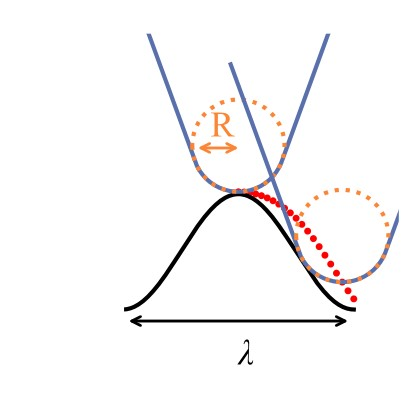

AFM resolution is commonly indicated by reference to structures that are at least locally periodic, for example, in atomic resolution mapping at a solid-liquid interface, in identification of recurrent features in a two-dimensional lattice of membrane proteins, or the distinction of the two strands of the double helix along a DNA molecule. Therefore, we considered AFM measurements on a periodic soft material where simulations focused on the compression produced from a single scan along the centre axis of the structures. As shown above, the structure has a wavelength $\lambda = 10nm$ and amplitude, $A_{Sample} = 10nm $. 

## Flow Chart

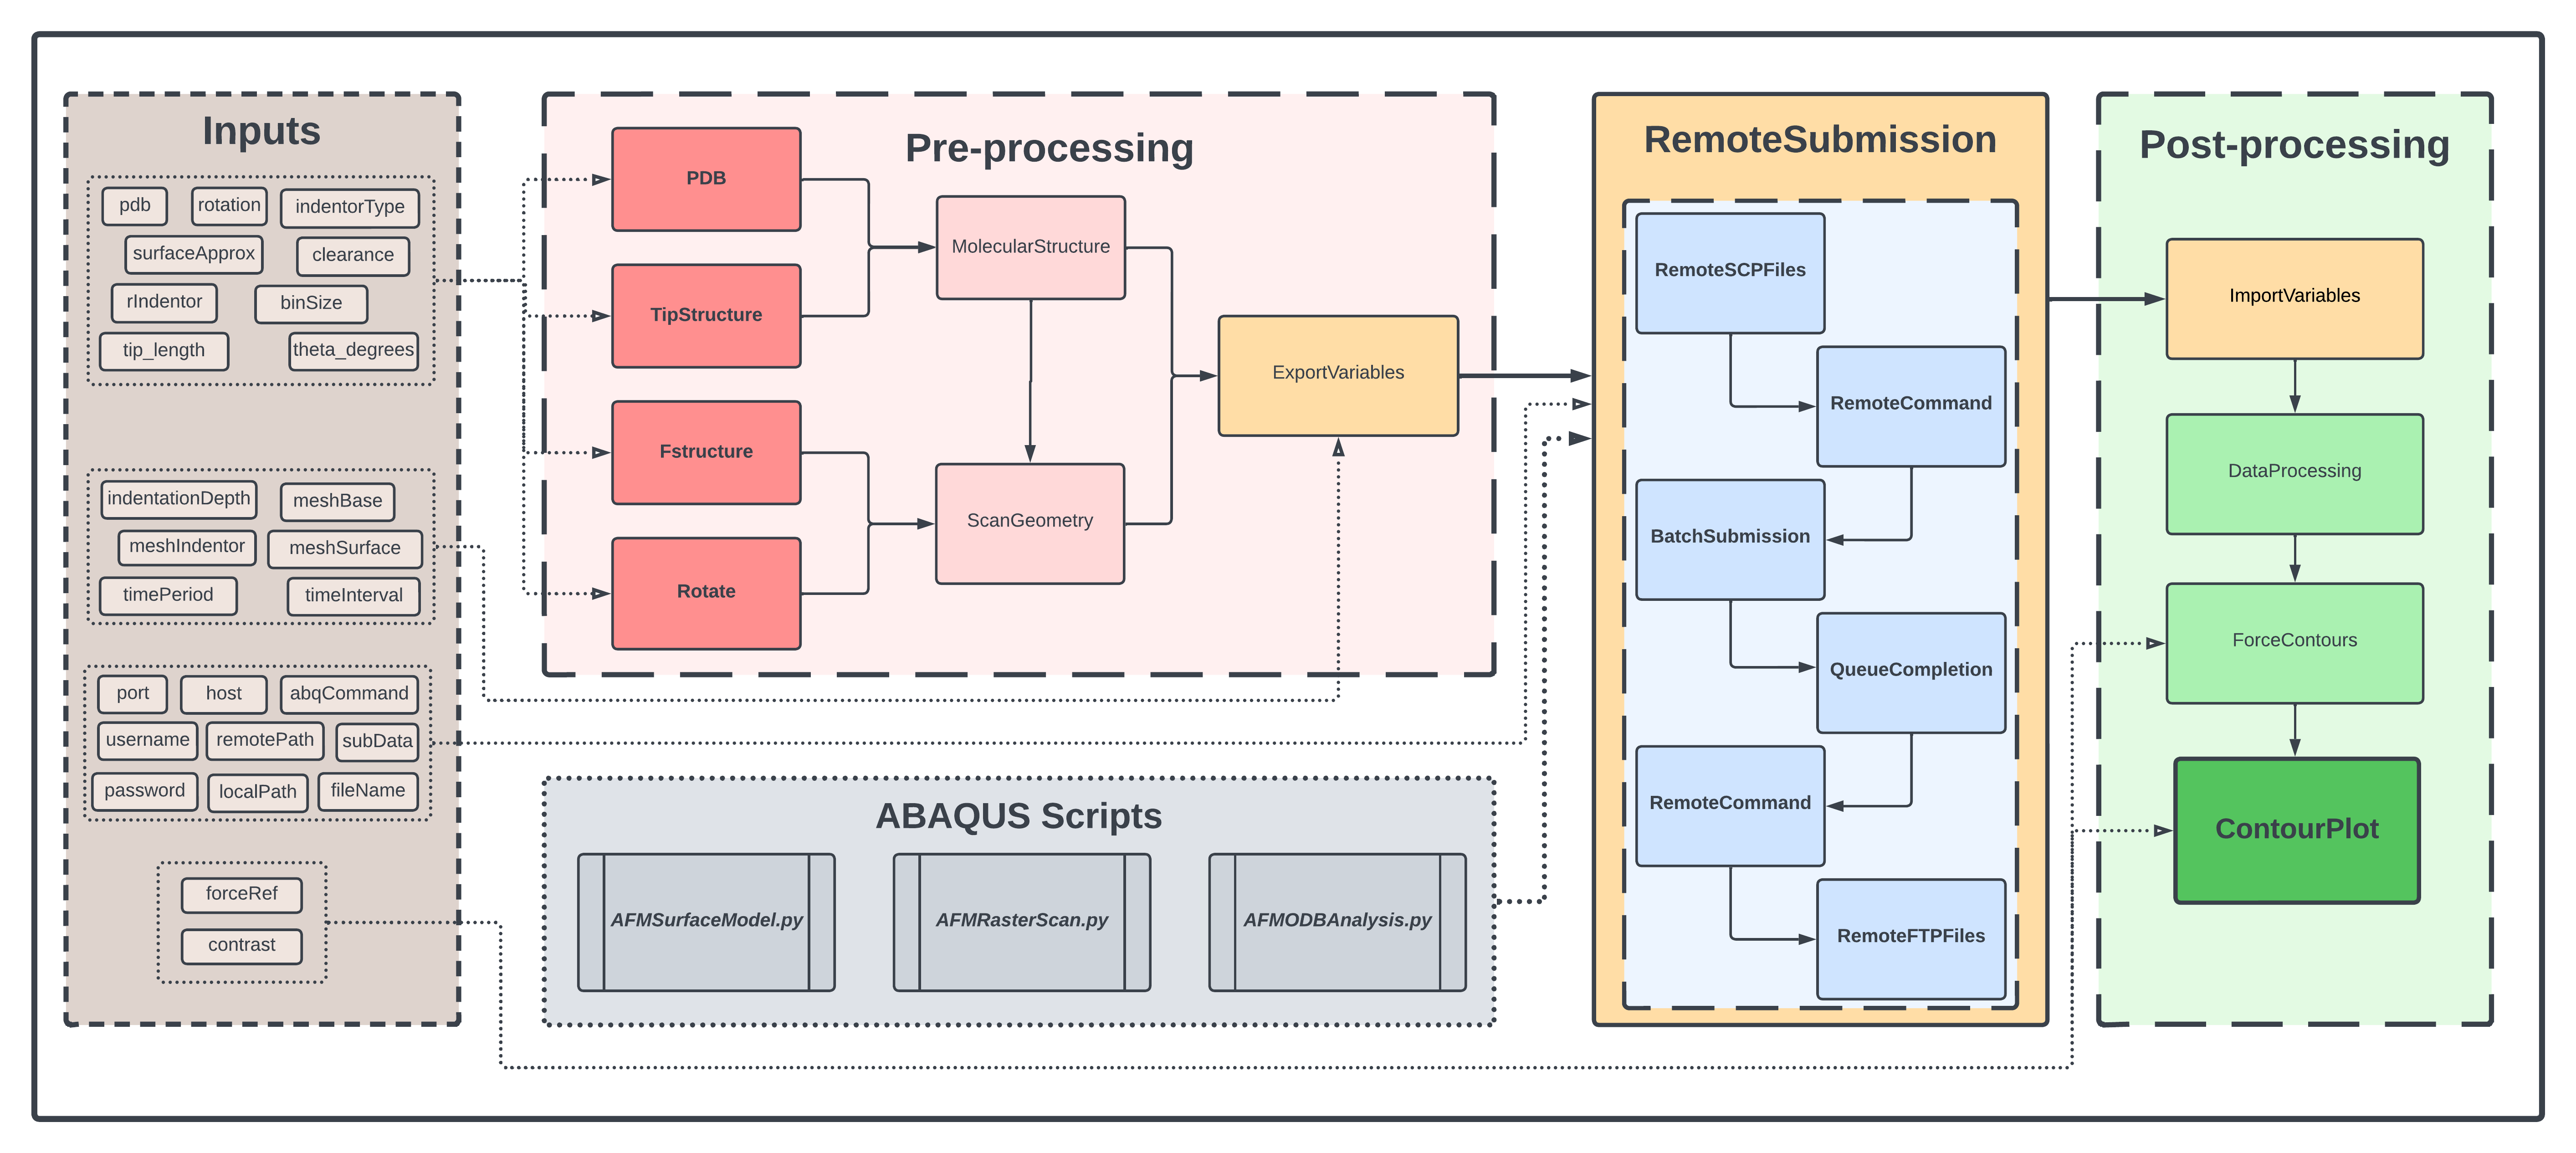

# Code Framework

## Imports

In [1]:
# -------------------------------------- Possible modules to pip instal-------------------------------------------------
# import sys
# !{sys.executable} -m pip install pyabaqus==2022
# !{sys.executable} -m pip install paramiko

In [2]:
# --------------------------------------------------System Imports-----------------------------------------------------
import os
import sys
import time
import subprocess
from datetime import timedelta
import paramiko
import socket
from scp import SCPClient

# ---------------------------------------------Mathematical/Plotting Imports--------------------------------------------
# Importing relevant maths and graphing modules
import numpy as np 
import math
from numpy import random   
from random import randrange

# Interpolation/ Fittting modules
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Plotting import and settinngs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

linewidth = 11.69/2 # inch

plt.rcParams["figure.figsize"] = (linewidth/3, 1/1.61*linewidth/3)
plt.rcParams['figure.dpi'] = 256
plt.rcParams['font.size'] = 13
plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# For displaying images in Markdown and  animation import
from IPython.display import Image 
from IPython.display import clear_output

## ABAQUS Scripts

ABAQUS is run automatically using seperate python scripts defined below. These are transfered to remote server and run using bash commands to produce input files before running simulations.

### Raster Scan AFM Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to create ABAQUS input files at each position in the raster scan. These are used to performm the independent analysis/ simulation at each position.

In [3]:
%%writefile AFMtestRasterScan.py

# ----------------------------------------------Load Modules-----------------------------------------------------------
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
#from abaqus import getInput
executeOnCaeStartup()

# ------------------------------------------------Set variables-------------------------------------------------------
with open('indentorType.txt', 'r') as f:
    indentorType = f.read()

variables = np.loadtxt('variables.csv', delimiter=",")
elasticProperties =  np.loadtxt('elasticProperties.csv', delimiter=",")

waveDims = np.loadtxt('waveDims.csv', delimiter=",")
wavePos  = np.loadtxt('wavePos.csv', delimiter=",")
tipDims  = np.loadtxt('tipDims.csv', delimiter=",")
rackPos  = np.loadtxt('rackPos.csv', delimiter=",")

timePeriod, timeInterval, binSize, indentionDepth, meshIndenter, meshSurface = variables
rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims 
waveLength, waveAmplitude, waveWidth, groupNum = waveDims

#  -------------------------------------------------Model-------------------------------------------------------------
modelName = 'AFMtestRasterScan'
model = mdb.Model(name=modelName)

# ------------------------------------------------Set Parts----------------------------------------------------------- 
# Create Surface part 
model.ConstrainedSketch(name = 'surface', sheetSize=1.0)   
model.sketches['surface'].ConstructionLine( point1=(-waveLength*groupNum/2,0), point2=(waveLength*groupNum/2,0) )
model.sketches['surface'].Spline(points= tuple(map(tuple,wavePos)))
model.sketches['surface'].Line(point1 = tuple(wavePos[0]), point2 = tuple(wavePos[0]-np.array([0, 2*waveAmplitude])))
model.sketches['surface'].Line(point1 = tuple(wavePos[0]-np.array([0, 2*waveAmplitude])), 
                               point2 = tuple(wavePos[-1]-np.array([0, 2*waveAmplitude])))
model.sketches['surface'].Line(point1 = tuple(wavePos[-1]-np.array([0, 2*waveAmplitude])), point2 = tuple(wavePos[-1]))
                                 
model.Part(dimensionality=THREE_D, name='surface', type= DEFORMABLE_BODY)
model.parts['surface'].BaseSolidExtrude(depth=waveWidth, sketch=model.sketches['surface'])

if indentorType == 'Capped':
    # Create Capped-Conical Indentor
    sketch = model.ConstrainedSketch(name = 'indentor', sheetSize=1.0)   
    model.sketches['indentor'].ConstructionLine(point1=(0,-rIndentor),point2=(0,z_top))
    model.sketches['indentor'].Line(point1=(r_int,z_int), point2=(r_top,z_top))
    model.sketches['indentor'].Line(point1=(0,-rIndentor), point2=(0,z_top))
    model.sketches['indentor'].Line(point1=(0,z_top), point2=(r_top,z_top))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0), point1=(r_int,z_int), point2=(0,-rIndentor),
                                               direction =CLOCKWISE)  
    model.Part(name='indentor', dimensionality=THREE_D, type= DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseShellRevolve(angle=360.0, flipRevolveDirection=OFF, sketch=model.sketches['indentor'])

else:
    # # Create Spherical Indentor part
    model.ConstrainedSketch(name = 'indentor', sheetSize=1.0)   
    model.sketches['indentor'].ConstructionLine(point1=(0,rIndentor),point2=(0,-rIndentor))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0),point1=(0,rIndentor),point2=(0,-rIndentor), 
                                               direction = CLOCKWISE)
    model.sketches['indentor'].Line(point1=(0,rIndentor),point2=(0,-rIndentor))
    model.Part(name='indentor', dimensionality=THREE_D, type=DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseShellRevolve( angle=360.0, flipRevolveDirection=OFF, sketch=model.sketches['indentor'])


# ----------------------------------------------Set Geometry----------------------------------------------------------
# Create geometric sets for faces and cells
model.parts['surface'].Set(faces= model.parts['surface'].faces.getSequenceFromMask(mask=('[#1]', ), ),
                           name='surface_faces')
model.parts['surface'].Set(cells= model.parts['surface'].cells.getSequenceFromMask(mask=('[#1]', ), ), 
                         name='surface_cells')
model.parts['surface'].Set(faces= model.parts['surface'].faces.getSequenceFromMask(mask=('[#4]', ), ), 
                           name='surface_base')


if indentorType == 'Capped':
    # Spherically Capped
    model.parts['indentor'].Set(faces= model.parts['indentor'].faces.getSequenceFromMask(mask=('[#7]', ), ),
                                name='indentor_faces')
else: 
    # Spherical
    model.parts['indentor'].Set(faces= model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1]', ), ),
                                name='indentor_faces')
    
# Create gemoetric surface for contact
model.parts['surface'].Surface(name='surface_surface', 
                               side1Faces = model.parts['surface'].faces.getSequenceFromMask(mask=('[#1]', ), ) )

if indentorType == 'Capped':
    # Spherically Capped
    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Faces = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#7]', ), ))
else:
    # Spherical
    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Faces = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1]', ), ))

# Create reference points
point = model.parts['surface'].ReferencePoint((0, 0, waveWidth/2))
model.parts['surface'].Set(referencePoints=(model.parts['surface'].referencePoints[point.id],),
                           name='surface_centre')
point = model.parts['indentor'].ReferencePoint((0, 0, 0))
model.parts['indentor'].Set(referencePoints = (model.parts['indentor'].referencePoints[point.id],),
                            name = 'indentor_centre')


# -----------------------------------------------Set Properties-------------------------------------------------------
# Assign materials
elastic = (tuple(elasticProperties), )
viscoelastic = ((0.0403,0,0.649),(0.0458,0,1.695),)

# Surface material assignment optional add viscoelastic
model.Material(name='surface_material')
model.materials['surface_material'].Elastic(table = elastic)
# model.materials['surface_material'].Viscoelastic(domain = FREQUENCY, frequency = PRONz, table = viscoelastic )
model.HomogeneousSolidSection(name='section', material='surface_material', thickness=None)
model.parts['surface'].SectionAssignment(region=model.parts['surface'].sets['surface_cells'],sectionName='section')

# ----------------------------------------------Set Assembly----------------------------------------------------------
model.rootAssembly.Instance(name='surface', part = model.parts['surface'],dependent=ON)
model.rootAssembly.Instance(name='indentor', part = model.parts['indentor'], dependent=ON)
model.rootAssembly.DatumCsysByDefault(CARTESIAN)

# Position base 
model.rootAssembly.translate(instanceList = ('surface',), vector=(0.0,0.0, -waveWidth/2))

# ------------------------------------------------Set Steps-----------------------------------------------------------
model.StaticStep(name='Indentation', previous='Initial', description='', timePeriod=timePeriod, 
                 timeIncrementationMethod=AUTOMATIC, maxNumInc=int(1e5), initialInc=0.1, minInc=1e-20, maxInc=1)
model.steps['Indentation'].control.setValues(allowPropagation=OFF, resetDefaultValues=OFF, 
                                             timeIncrementation=(4.0, 8.0, 9.0, 16.0, 10.0, 4.0, 12.0, 25.0, 6.0, 3.0,
                                                                 50.0))
field = model.FieldOutputRequest('F-Output-1', createStepName='Indentation', variables=('RF', 'TF', 'U'), 
                                 timeInterval = timeInterval)


# ----------------------------------------------Set Interactions------------------------------------------------------
model.ContactProperty(name ='Contact Properties')
model.interactionProperties['Contact Properties'].TangentialBehavior(formulation =ROUGH)
model.interactionProperties['Contact Properties'].NormalBehavior(pressureOverclosure=HARD)

model.RigidBody(name = 'indentor_constraint', 
                bodyRegion = model.rootAssembly.instances['indentor'].sets['indentor_faces'],
                refPointRegion = model.rootAssembly.instances['indentor'].sets['indentor_centre'])


model.SurfaceToSurfaceContactStd(name = 'surface-indentor', 
                                 createStepName = 'Initial', 
                                 master = model.rootAssembly.instances['indentor'].surfaces['indentor_surface'], 
                                 slave  = model.rootAssembly.instances['surface'].surfaces['surface_surface'],
                                 interactionProperty = 'Contact Properties', 
                                 sliding = FINITE)

# -----------------------------------------------Set Loads------------------------------------------------------------
# Create surface boundary conditions
model.DisplacementBC(name = 'Surface-BC', createStepName = 'Initial', 
                     region = model.rootAssembly.instances['surface'].sets['surface_base'], 
                     u1 = SET, u2 = SET, u3 = SET, ur1 = SET, ur2 = SET, ur3 = SET)

# Create indentor boundary conditions
model.DisplacementBC(name = 'Indentor-UC', createStepName = 'Indentation',                  
                     region = model.rootAssembly.instances['indentor'].sets['indentor_centre'], 
                     u1  = SET, u2  = -indentionDepth, u3  = SET,
                     ur1 = SET, ur2 = SET,             ur3 = SET)


# ------------------------------------------------Set Mesh------------------------------------------------------------
#Assign an element type to the part instance- seed and generate
model.rootAssembly.regenerate()

elemType1 = mesh.ElemType(elemCode=C3D20R, elemLibrary=STANDARD)
elemType2 = mesh.ElemType(elemCode=C3D15, elemLibrary=STANDARD)
elemType3 = mesh.ElemType(elemCode=C3D10, elemLibrary=STANDARD, secondOrderAccuracy=ON, distortionControl=DEFAULT)
cells     = model.parts['surface'].cells.getSequenceFromMask(mask=('[#1 ]', ), )

model.parts['surface'].seedPart(size=meshSurface, minSizeFactor=0.1)
model.parts['surface'].setMeshControls(regions=cells, elemShape=TET, technique=FREE)
model.parts['surface'].setElementType(regions=(cells,), elemTypes=(elemType1, elemType2, elemType3))
model.parts['surface'].generateMesh()


elemType1 = mesh.ElemType(elemCode=R3D4, elemLibrary=STANDARD)
elemType2 = mesh.ElemType(elemCode=R3D3, elemLibrary=STANDARD)
faces     = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1 ]', ),)

model.parts['indentor'].seedPart(size= meshIndenter, minSizeFactor=0.25)
model.parts['indentor'].setMeshControls(regions=faces, elemShape=TRI)
model.parts['indentor'].setElementType(regions=(faces,), elemTypes=(elemType1, elemType2))
model.parts['indentor'].generateMesh()

# ----------------------------------------------Set Submission--------------------------------------------------------
for i in range(len(rackPos)):
    jobName = 'AFMtestRasterScan-Pos'+str(int(i))
    model.rootAssembly.translate(instanceList = ('indentor',),vector=(rackPos[i,0],rackPos[i,1]+rIndentor,0))
    job = mdb.Job(name=jobName, model=modelName, description='AFM Sphere')
    job.writeInput()    
    model.rootAssembly.translate(instanceList = ('indentor',),vector=(-rackPos[i,0], -rackPos[i,1]-rIndentor, 0))
    
mdb.saveAs('AFMRaster.cae')

Overwriting AFMtestRasterScan.py


### ODB Analysis Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to analysis odb files for each position in the raster scan. Extracting indentation data.

In [4]:
%%writefile AFMtestODBAnalysis.py

# ----------------------------------------------Load Modules-----------------------------------------------------------
import sys
from odbAccess import *
from types import IntType
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
#from abaqus import getInput
executeOnCaeStartup()

# ------------------------------------------------Set variables-------------------------------------------------------
variables = np.loadtxt('variables.csv', delimiter=",")
rackPos    = np.loadtxt('rackPos.csv', delimiter=",")

timePeriod, timeInterval, binSize, indentionDepth, meshIndenter, meshSurface = variables

N = int(timePeriod/ timeInterval)+1
RF = np.zeros([len(rackPos),N])
U2 = np.zeros([len(rackPos),N])

# --------------------------------------------Set Data extraction---------------------------------------------------
for i in range(len(rackPos)):
    jobName = 'AFMtestRasterScan-Pos' + str(int(i))
    try :
        # Opening the odb
        odb    = openOdb(jobName +'.odb', readOnly=True)
        region = odb.rootAssembly.nodeSets.values()[1]
    except:        
        with open('Errors.txt', 'a') as f:
            f.write('ERROR for'+str(i)+'\n')
    else:          
        # Extracting Step 1, this analysis only had one step
        step1 = odb.steps.values()[0]
        
        j,k = 0, 0 
        # Creating a for loop to iterate through all frames in the step
        for x in odb.steps[step1.name].frames:
            # Reading stress and strain data from the model 
            fieldRF = x.fieldOutputs['RF'].getSubset(region= region)
            fieldU  = x.fieldOutputs['U'].getSubset(region= region)    

            # Storing Stress and strain values for the current frame
            for rf in fieldRF.values:
                RF[i,j] = np.sqrt(rf.data[1]**2)
                j+=1

            for u in fieldU.values:
                U2[i,k] = u.data[1] 
                k+=1   

# Writing to a .csv file
np.savetxt('U2_Results.csv', U2 , delimiter=",")
np.savetxt('RF_Results.csv', RF , delimiter=",")   

# Close the odb
odb.close()    

Overwriting AFMtestODBAnalysis.py


## Simulation Code Functions
Functionalised code to automate scan and geometry calculations, remote server access, remote script submission, data anlaysis and postprocessing required to produce AFM image.

### Pre-Processing Function
Functions used in preprocessing step of simulation, including calculating scan positions and exporting variables.

#### Tip Functions
Functions to produce list of tip structural parameters, alongside function to calculates and returns tip surface heights from radial  position r.

In [5]:
def TipStructure(rIndentor, theta_degrees, tip_length): 
    '''
    Produce list of tip structural parameters. Change principle angle to radian. Calculate tangent point where 
    sphere smoothly transitions to cone for capped conical indentor.
    
        Parameters:
            theta_degrees (float) - Principle conical angle from z axis in degrees
            rIndentor (float)     - Radius of spherical tip portion
            tip_length (float)    - Total cone height
            
        Returns:
            tipDims (list) - Geometric parameters for defining capped tip structure     
    '''
    theta = theta_degrees*(np.pi/180)
    
    # Intercept of spherical and conical section of indentor (Tangent point) 
    r_int, z_int = rIndentor*abs(np.cos(theta)), -rIndentor*abs(np.sin(theta))
    # Total radius/ footprint of indentor/ top coordinates
    r_top, z_top = (r_int+(tip_length-r_int)*abs(np.tan(theta))), tip_length-rIndentor
    
    return [rIndentor, theta, tip_length, r_int, z_int, r_top, z_top]

In [6]:
def Fconical(r, r0, r_int, z_int, theta, R, tip_length):
    '''
    Calculates and returns spherically capped conical tip surface heights from radial  position r. Uses radial coordinate along
    xz plane from centre as tip is axisymmetric around z axis (bottom of tip set as zero point such z0 = R).
    
        Parameters:
            r (float/1D arr)   - xz radial coordinate location for tip height to be found
            r0 (float)         - xz radial coordinate for centre of tip
            r_int (float)      - xz radial coordinate of tangent point (point where sphere smoothly transitions to cone)
            z_int (float)      - Height of tangent point, where sphere smoothly transitions to cone (defined for tip centred at spheres 
                                 center, as calculations assume tip centred at indentors bottom the value must be corrected to, R-z_int) 
            theta (float)      - Principle conical angle from z axis in radians
            R (float)          - Radius of spherical tip portion
            tip_length (float) - Total cone height
            
        Returns:
            Z (float/1D arr)- Height of tip at xz radial coordinate 
    '''
    
    ### Constructing conical and spherical parts boundaries of tip using arrays for computation speed
    
    # ------------------------------------------------Spherical Boundary------------------------------------------------
    # For r <= r_int, z <= z_int : (z-z0)^2 +  (r-r0)^2 = R^2 --> z = z0  + ( R^2 - (r-r0)^2 )^1/2   
    
    # Using equation of sphere compute height (points outside sphere radius are complex and return nan, 
    # nan_to_num is used to set these points to max value R). The heights are clip to height of tangent point, R-z_int. 
    # Producing spherical portion for r below tangent point r_int and constant height R-zint for r values above r_int.
    
    z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))
    # z1 = np.clip( np.where( np.isnan( R - np.sqrt(R**2 - (r-r0)**2) ) , R, R - np.sqrt(R**2 - (r-r0)**2) ), a_min = 0 , a_max = R-np.abs(z_int))

    # -------------------------------------------------Conical Boundary-------------------------------------------------
    # r > r_int, z > z_int : z = m*abs(x-x0);  where x = r, x0 = r0 + r_int,  m = 1/tan(theta)
    
    # Using equation of cone (line) to compute height for r values larger than tangent point r_int (using where condition) 
    # For r values below r_int the height is set to zero
    
    z2 =np.where(abs(r-r0)>=r_int, (abs(r-r0)-r_int)/abs(np.tan(theta)), 0)
    
    # ------------------------------------------------Combing Boundaries------------------------------------------------
    # For r values less than r_int, combines spherical portion with zero values from conical, producing spherical section
    # For r values more than r_int, combines linear conical portion with R-z_int values from spherical, producing cone section
    Z = z1 + z2 
    
    # Optional mask values greater than tip length
    # Z = np.ma.masked_greater(z1+z2, tip_length )
    return Z

In [7]:
def Fspherical(r, r0, r_int, z_int, theta, R, tip_length):
    '''
    Calculates and returns spherical tip surface heights from radial  position r. Uses radial coordinate along xz plane from 
    centre as tip is axisymmetric around z axis (bottom of tip set as zero point such z0 = R).
    
        Parameters:
            r (float/1D arr)   - xz radial coordinate location for tip height to be found
            r0 (float)         - xz radial coordinate for centre of tip
            r_int (float)      - xz radial coordinate for tangent point (point where sphere smoothly transitions to cone)
            z_int (float)      - Height of tangent point (point where sphere smoothly transitions to cone)
            theta (float)      - Principle conical angle from z axis in radians
            R (float)          - Radius of spherical tip portion
            tip_length (float) - Total cone height
            
        Returns:
            Z (float/1D arr)- Height of tip at xz radial coordinate 
    '''
    # Simple spherical equation: (z-z0)^2 +  (r-r0)^2 = R^2 --> z = z0  - ( R^2 - (r-r0)^2 )^1/2  
    return ( R - np.sqrt(R**2 - (r-r0)**2) ) 

#### Scan Functions
Calculate scan positions of tip over surface and vertical set points above surface for each position. In addition, function to plot and visualise molecules surface and scan position.

In [8]:
def waveSin(x, waveDims):
    '''Function defining wave shaped surface'''
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    A      = waveAmplitude/2
    omega  = 2*np.pi/waveLength
    phi    = -np.pi/2
    return A*(np.sin(omega*x+phi)+1)

In [9]:
def ScanGeometry(indentorType, tipDims, waveDims, Nb, clearance):
    ''' 
    Produces array of scan locations and corresponding heights/ tip positions above surface in Angstroms (x10-10 m).The scan positions are produced creating a 
    straight line along the centre of the surface with positions spaced by the bin size. Heights, at each position, are calculated for conical indentor by set 
    tip above sample and calculating vertical distance between of tip and molecules surface over the indnenters area. Subsequently, the minimum vertical distance 
    corresponds to the position where tip is tangential. Spherical indentors are calculated explicitly.
    
        Parameters:
            indentorType (str) - String defining indentor type (Spherical or Capped)
            tipDims (list)     - Geometric parameters for defining capped tip structure     
            waveDims (list)    - Geometric parameters for defining base/ substrate structure [wavelength, amplitude, width] 
            Nb (int)           - Number of scan positions along x axis of base
            clearance (float)  - Clearance above molecules surface indentor is set to during scan
            
        Returns:
            rackPos (arr) - Array of coordinates [x,z] of scan positions to image biomolecule 
    '''
    #  -------------------------------------Set Rack Positions from Scan Geometry---------------------------------------------
    # Set variables
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    [rIndentor, theta, tip_length, r_int, z_int, r_top, z_top] = tipDims
    
    # Intialise array of raster scan positions
    rackPos = np.zeros([Nb,2])
    
    # Create linear set of scan positions over base, along x axis, for half a wave length
    rackPos[:,0] = np.linspace(-waveLength/2, 0, Nb)  
    
    
    # ------------------------------------------------Set Indentor variables---------------------------------------------------
    # Set indentor height functions and indentor radial extent/boundry for initial height calculation.
    if indentorType == 'Capped': 
        # Extent of conical indentor is the radius of the top portion
        rBoundary = r_top
        F = Fconical
        
    else:
        # Extent of spherical indentor is the radius
        rBoundary = rIndentor
        F = Fspherical

    #  ---------------------------------------------Calculate Rack Positions -------------------------------------------------
    for i, rPos in enumerate(rackPos[:,0]):
        # Array of radial positions along indentor radial extent. Set indentor position/ coordinate origin at surface height 
        # (z' = z + surfaceHeight) and calculate  vertical heights along the radial extent of indentor at position. 
        r0 = np.linspace(rPos-rBoundary, rPos+rBoundary, 1000)
        z0 = F(r0, rPos, r_int, z_int, theta, rIndentor, tip_length) + waveAmplitude

        # Using equation of sphere compute top heights of atoms surface along indentors radial extent (points outside sphere 
        # radius are complex and return nan, nan_to_num is used to set these points to the min value of bases surface z=0).
        z  = waveSin(r0, waveDims)

        # The difference in the indentor height and the surface at each point along indenoter extent, produces a dz
        # array of all the height differences between indentor and surface within the indentors boundary around this position.
        # Therefore, z' = -dz  gives an array of indentor positions when each individual part of surface atoms contacts the tip portion above.
        # Translating from z' basis (with origin at z = surfaceHeight) to z basis (with origin at the top of the base) is achieved by
        # perform translation z = z' + surfaceheight. Therefore, these tip position are given by  dz = surfaceheight - dz'. The initial height 
        # corresponds to the maximum value of dz/ min value of dz' where the tip is tangential to the surface. I.e. when dz' is minimised 
        # all others dz' tip positions will be above/ further from the surface. Therefore, at this position, the rest of the indentor wil 
        # not be in contact with the surface and it is tangential. 

        rackPos[i,1] = waveAmplitude - abs((z0-z).min()) + clearance    
    
    return rackPos

### Remote Functions
Functions for working on remote serve, including transfering files, submitting bash commands, submiting bash scripts for batch input files and check queue statis.

#### File Import/ Export Function

In [43]:
def ExportVariables(rackPos, variables, waveDims, wavePos, tipDims, indentorType, elasticProperties):
    ''' 
    Export simulation variables as csv and txt files to load in abaqus python scripts.
    
        Parameters:
            rackPos (arr)           - Array of coordinates [x,z] of scan positions to image biomolecule 
            variables (list)        - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, 
                                      indentionDepth, surfaceHeight]
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [wavelength, amplitude, width] 
            wavePos (arr)           - Positions on wave used to define spline in ABAQUS
            tipDims (list)          - Geometric parameters for defining capped tip structure     
            indentorType (str)      - String defining indentor type (Spherical or Capped)
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
    '''
    ### Creating a folder on the Users system
    os.makedirs('data', exist_ok=True)

    np.savetxt("data"+os.sep+"elasticProperties.csv", elasticProperties, fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"variables.csv", variables, fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"rackPos.csv", rackPos, fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"wavePos.csv", wavePos, delimiter=",")
    np.savetxt("data"+os.sep+"waveDims.csv", waveDims, fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"tipDims.csv", tipDims, fmt='%s', delimiter=",")
    
    with open('indentorType.txt', 'w', newline = '\n') as f:
        f.write(indentorType)

In [11]:
def ImportVariables():
    ''' 
    Import simulation geometry variables from csv files.
    
        Return:
            variables (list)        - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight]
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [wavelength, amplitude, width, group number]             
            rackPos (arr)           - Array of coordinates [x,z] of scan positions to image biomolecule  
    '''

    ### Creating a folder on the Users system
    os.makedirs('data', exist_ok=True)

    variables = np.loadtxt("data"+os.sep+"variables.csv", delimiter=",")
    waveDims  = np.loadtxt("data"+os.sep+"waveDims.csv", delimiter=",")
    rackPos   = np.loadtxt("data"+os.sep+"rackPos.csv", delimiter=",")
    
    return variables, waveDims, rackPos

#### Remote Connection

In [12]:
def SSHconnect(remote_server, **kwargs):
    ''' Function to open ssh connecction to remote server. A new Channel is opened and allows requested command to be executed in other functions. 
    The function allows for ProxyJumpp/Port Forwarding/SSH Tunelling.

        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                                    host (str)       - Hostname of the server to connect to
                                    port (int)       - Server port to connect to 
                                    username (str)   - username to authenticate as (defaults to the current local username)        -  
                                    password (str)   - Used for password authentication, None if ssh-key is used; is also used for private key 
                                                       decryption if passphrase is not given.
                                    sshkey (str)     - Path to private key for keyexchange if password not used, None if not used
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
                                           
        Return: 
            ssh_client (obj) - SHH client object which allows for bash command execution and file transfer.
    '''

    host, port, username, password, sshkey, home, scratch = remote_server

    if 'ProxyJump' in kwargs:
        # Set variables for proxy port
        proxy_host, proxy_port, proxy_username, proxy_password, proxy_sshkey, proxy_home, proxy_scratch = kwargs['ProxyJump']
        hostname = socket.getfqdn()
        remote_addr = (host, int(port))
        local_addr  = (socket.gethostbyname_ex(hostname)[2][0], 22)

        # Create proxy jump/ ssh tunnel
        proxy_client = paramiko.SSHClient()
        proxy_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        proxy_client.connect(proxy_host, int(proxy_port), proxy_username, proxy_password, key_filename=proxy_sshkey)
        transport = proxy_client.get_transport()
        channel = transport.open_channel("direct-tcpip", remote_addr, local_addr)

        # SSH to clusters using paramiko module
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(host, int(port), username, password, key_filename=sshkey, sock=channel)
    
    else: 
        # SSH to clusters using paramiko module
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(host, int(port), username, password, key_filename=sshkey)

    return ssh_client

#### File Transfer

In [13]:
def RemoteSCPFiles(remote_server, files, remotePath, **kwargs):
    '''    
    Function to make directory and transfer files to SSH server. A new Channel is opened and the files are transfered. 
    The commands input and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            files (list)         - File or list of file to transfer
            remotePath (str)     - Path to remote file/directory
            
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    # SHH to clusters
    ssh_client = SSHconnect(remote_server, **kwargs)
    stdin, stdout, stderr = ssh_client.exec_command('mkdir -p ' + remotePath)

    # SCPCLient takes a paramiko transport as an argument- Uploading content to remote directory
    scp_client = SCPClient(ssh_client.get_transport())
    scp_client.put(["data"+os.sep+file for file in files], recursive=True, remote_path = remotePath)
    scp_client.close()
    
    ssh_client.close()

#### Bash Command Submission

In [14]:
def RemoteCommand(remote_server, script, remotePath, command, **kwargs):
    '''
    Function to execute a command/ script submission on the SSH server. A new Channel is opened and the requested command is executed. 
    The commands input and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            script (str)         - Script to run via bash command 
            remotePath (str)     - Path to remote file/directory
            command (str)        - Abaqus command to execute and run script   
                     
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    
    ssh_client = SSHconnect(remote_server, **kwargs)
    # Execute command
    stdin, stdout, stderr = ssh_client.exec_command('cd ' + remotePath + ' \n '+ command +' '+ script +' & \n')
    lines = stdout.readlines()

    ssh_client.close()
    
    for line in lines:
        print(line)

#### Batch File Submission

In [15]:
def BatchSubmission(remote_server, fileName, subData, scanPos, remotePath, **kwargs):
    ''' 
    Function to create bash script for batch submission of input file, and run them on remote server.
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            fileName (str)       - Base File name for abaqus input files
            subData (str)        - Data for submission to serve queue [walltime, memory, cpus]
            scanPos (arr)        - Array of coordinates [x,y] of scan positions to image biomolecule (can be clipped or full) 
            remotePath (str)     - Path to remote file/directory
            
            kwargs:
                ProxyJump (proxy_server)          - Optional define whether to use a Proxy Jump to ssh through firewall. Defines varibles for proxy server 
                                                    in list format [host, port, username, password, sshkey, home, scratch]
                Submission ('serial'/ 'paralell') - Optional define whether single serial script or seperate paralell submission to queue {Default: 'serial'}  
    '''
    # For paralell mode create bash script to runs for single scan location, then loop used to submit individual scripts for each location which run in paralell
    if 'Submission' in kwargs and kwargs['Submission'] == 'paralell':
        jobs = 'abaqus interactive cpus=$NSLOTS mp_mode=mpi job=$JOB_NAME input=$JOB_NAME.inp scratch=$ABAQUS_PARALLELSCRATCH resultsformat=odb'
        
    # Otherwise, create script to run serial analysis consecutively with single submission
    else:
        # Create set of submission comands for each scan locations
        jobs = ['abaqus interactive cpus=$NSLOTS memory="90%" mp_mode=mpi standard_parallel=all job='+fileName+str(int(i))+' input='+fileName+str(int(i))+'.inp scratch=$ABAQUS_PARALLELSCRATCH' 
                for i in range(len(scanPos))]
    
    # Produce preamble to used to set up bash script
    scratch = remote_server[-1]
    lines = ['#!/bin/bash -l',
             '#$ -S /bin/bash',
             '#$ -l h_rt='+ subData[0],
             '#$ -l mem=' + subData[1],
             '#$ -pe mpi '+ subData[2],
             '#$ -wd '+scratch,
             'module load abaqus/2017 ',
             'ABAQUS_PARALLELSCRATCH="'+scratch+'" ',
             'cd ' + remotePath 
            ]
        
    # Combine to produce total  script
    lines+=jobs

    # Create script file in current directory by writing each line to file
    with open('batchScript.sh', 'w', newline = '\n') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

    # SSH to clusters 
    ssh_client = SSHconnect(remote_server, **kwargs)
    stdin, stdout, stderr = ssh_client.exec_command('mkdir -p ' + remotePath)

    # SCPCLient takes a paramiko transport as an argument- Uploading content to remote directory
    scp_client = SCPClient(ssh_client.get_transport())
    scp_client.put('batchScript.sh', recursive=True, remote_path = remotePath)
    scp_client.close()
    
    # If paralell mode, submit  individual scripts for individual scan locations
    if 'Submission' in kwargs and kwargs['Submission'] == 'paralell':
        for i in range(len(scanPos)):
            # Job name set as each input file name as -N jobname is used as input variable in script
            jobName = fileName+str(int(i))
            
            # Command to run individual jobs
            batchCommand = 'cd ' + remotePath + ' \n qsub -N '+ jobName +' batchScript.sh \n'

            # Execute command
            stdin, stdout, stderr = ssh_client.exec_command(batchCommand)
            lines = stdout.readlines()
            print(lines)
    
    # Otherwise submit single serial scripts
    else:
        # Job name set as current directory name (change / to \\ for windows)
        jobName = remotePath.split('/')[-1]
        batchCommand = 'cd ' + remotePath + ' \n qsub -N '+ jobName +' batchScript.sh \n'

        # Execute command
        stdin, stdout, stderr = ssh_client.exec_command(batchCommand)
        lines = stdout.readlines()
        print(lines)
        
    ssh_client.close() 

#### Queue Status Function

In [16]:
def QueueCompletion(remote_server, **kwargs):
    '''
    Function to check queue statis and complete when queue is empty.
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                       
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    # Log time
    t0 = time.time()
    complete= False

    while complete == False:
        # SSH to clusters 
        ssh_client = SSHconnect(remote_server, **kwargs)

        # Execute command to view the queue
        stdin, stdout, stderr = ssh_client.exec_command('qstat')
        lines = stdout.readlines()
        
        # Check if queue is empty
        if len(lines)==0:
            print('Complete')
            complete = True
            ssh_client.close()   
        
        # Otherwis close and wait 2 mins before checking again
        else:
            ssh_client.close() 
            time.sleep(120)

    # Return total time
    t1 = time.time()
    print(t1-t0)

#### File Retrieval

In [17]:
def RemoteFTPFiles(remote_server, files, remotePath, localPath, **kwargs):
    ''' 
    Function to transfer files from directory on SSH server to local machine. A new Channel is opened and the files are transfered. 
    The function uses FTP file transfer.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            files (str )         - File to transfer
            remotePath (str)     - Path to remote file/directory
            localPath (str)      - Path to local file/directory

            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    ### Creating a folder on the Users system
    os.makedirs('data', exist_ok=True)
    
    # SSH to cluster
    ssh_client = SSHconnect(remote_server, **kwargs)

    # FTPCLient takes a paramiko transport as an argument- copy content from remote directory
    ftp_client=ssh_client.open_sftp()
    ftp_client.get(remotePath+'/'+files, localPath + os.sep + 'data'+ os.sep+ files)  
    ftp_client.close()

#### Remote Terminal

In [18]:
def Remote_Terminal(remote_server, **kwargs):
    '''    
    Function to emulate cluster terminal. Channel is opened and commands given are executed. The command’s input 
    and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                       
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    
    # SHH to cluster
    ssh_client = SSHconnect(remote_server, **kwargs)
    
    # Create channel to keep connection open
    ssh_channel = ssh_client.get_transport().open_session()
    ssh_channel.get_pty()
    ssh_channel.invoke_shell()
    
    # While open accept user input commands
    while True:
        command = input('$ ')
        if command == 'exit':
            break

        ssh_channel.send(command + "\n")
        
        # Return bash output from command
        while True:
            if ssh_channel.recv_ready():
                output = ssh_channel.recv(1024)
                print(output)
            else:
                time.sleep(0.5)
                if not(ssh_channel.recv_ready()):
                    break
    # Close cluster connection
    ssh_client.close()

### Submission Functions
Function to run simulation and scripts on the remote servers. Files for variables are transfered, ABAQUS scripts are run to create parts and input files. A bash file is created and submitted to run simulation for batch of inputs. Analysis of odb files is performed and data transfered back to local machine. Using keyword arguments invidual parts of simulation previously completed can be skipped.

In [19]:
def RemoteSubmission(remote_server, remotePath,  csvfiles, abqfiles, abqCommand, fileName, subData, rackPos, **kwargs):
    '''
    Function to run simulation and scripts on the remote servers. Files for variables are transfered, ABAQUS scripts are run to create parts and input files. 
    A bash file is created and submitted to run simulation for batch of inputs. Analysis of odb files is performed and data transfered back to local machine.
    Using keyword arguments can submitt the submission files in parrallel.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            remotePath (str)     - Path to remote file/directory
            csvfiles (list)      - List of csv and txt files to transfer to remote server
            abqfiles (list)      - List of abaqus script files to transfer to remote server
            abqCommand (str)     - Abaqus command to execute and run script
            fileName (str)       - Base File name for abaqus input files
            subData (str)        - Data for submission to serve queue [walltime, memory, cpus]
            rackPos (arr)        - Array of scan positions and initial height [x,z] to image 
            kwargs:
                ProxyJump (proxy_server)          - Optional define whether to use a Proxy Jump to ssh through firewall; defines varibles for proxy server in list format 
                                                    [host, port, username, password, sshkey, home, scratch]
                Submission ('serial'/ 'paralell') - Type of submission, submit pararlell scripts or single serial script for scan locations {Default: 'serial'}
             
    '''
    #  ---------------------------------------------File Transfer----------------------------------------------------------       
    # Transfer scripts and variable files to remote server
    RemoteSCPFiles(remote_server, csvfiles, remotePath, **kwargs)
    RemoteSCPFiles(remote_server, abqfiles, remotePath, **kwargs)

    print('File Transfer Complete')

    #  ----------------------------------------------Input File Creation----------------------------------------------------    
    t0 = time.time()
    print('Producing Input Files ...')

    # Produce simulation and input files
    script = 'AFMtestRasterScan.py'
    RemoteCommand(remote_server, script, remotePath, abqCommand, **kwargs)

    t1 = time.time()
    print('Input File Complete - ' + str(timedelta(seconds=t1-t0)) )

    #  --------------------------------------------Batch File Submission----------------------------------------------------
    t0 = time.time()
    print('Submitting Batch Scripts ...')

    # Submit bash scripts to remote queue to carry out batch abaqus analysis
    BatchSubmission(remote_server, fileName, subData, rackPos, remotePath, **kwargs) 

    t1 = time.time()
    print('Batch Submission Complete - '+ str(timedelta(seconds=t1-t0)) + '\n' )

In [44]:
def DataRetrieval(remote_server, wrkDir, localPath, csvfiles, dataFiles, indentorRadius, **kwargs):
    '''
    Function to retrieve simulation data transfered back to local machine. Using keyword arguments to change to compilation of simulations data.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            remotePath (str)     - Path to remote file/directory
            localPath (str)      - Path to local file/directory
            csvfiles (list)      - List of csv and txt files to transfer to remote server
            datafiles (list)     - List of abaqus script files to transfer to remote server
            indentorRadius (arr) - Array of indentor radii of spherical tip portion varied for seperate  simulations
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; defines varibles for proxy server in list format 
                                           [host, port, username, password, sshkey, home, scratch]
                Compile(int)             - If passed, simulation data is compiled from seperate sets of simulations in directory in remote server to combine 
                                           complete indentations. Value is set as int representing the range of directories to compile from (directories must have 
                                           same root naming convention with int denoting individual directories)
            
        Return:
            variables (list) - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshIndentor, indentionDepth]
            TotalU2 (arr)    - Array of indentors z displacement in time over scan position and  for all indenter [Ni, Nb, Nt]
            TotalRF (arr)    - Array of reaction force in time on indentor reference point over scan position  and for all indenter [Ni, Nb, Nt]
            NrackPos (arr)   - Array of initial scan positions for each indenter [Ni, Nb, [x, z] ]    
    '''  
    #  -------------------------------------------------Remote Variable------------------------------------------------------------
    # Import variables from remote server used for the simulations
    for file in csvfiles:    
        RemoteFTPFiles(remote_server, file, wrkDir+'/IndenterRadius7', localPath, **kwargs)
    
    # Set simulation variables used to process data
    variables, waveDims, rackPos  = ImportVariables()
    timePeriod, timeInterval, binSize, indentionDepth, meshIndentor, meshSurface = variables 
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims

    # Set array size variables
    Nb, Nt = int((waveLength/2)/(binSize) + 1), int(timePeriod/ timeInterval)+1

    #  -------------------------------------------Initialise data arrays----------------------------------------------------------
    NrackPos = np.zeros([len(indentorRadius), Nb, 2])
    TotalRF  = np.zeros([len(indentorRadius), Nb, Nt])
    TotalU2  = np.zeros([len(indentorRadius), Nb, Nt])    
    
    
    #  -------------------------------------------Compiled data retrieval----------------------------------------------------------   
    if 'Compile' in kwargs.keys():  

        # For number of directories set to compile
        for n in range(kwargs['Compile']):
            
            
            for index, rIndentor in enumerate(indentorRadius):
                # Set path to file
                remotePath = wrkDir[:-1] + str(n) + '/IndenterRadius'+str(int(rIndentor))
                
                # Check file is available
                try :
                    RemoteFTPFiles(remote_server, dataFiles[0], remotePath, localPath, **kwargs)
                    RemoteFTPFiles(remote_server, dataFiles[1], remotePath, localPath, **kwargs)
                    RemoteFTPFiles(remote_server, dataFiles[2], remotePath, localPath, **kwargs)

                except:
                    None

                else:
                    # If files are available load data in to temperary variable 
                    U2 = np.array(np.loadtxt("data"+os.sep+dataFiles[0], delimiter=","))
                    RF = np.array(np.loadtxt("data"+os.sep+dataFiles[1], delimiter=","))  
                    NrackPos[index] = np.array(np.loadtxt("data"+os.sep+dataFiles[2], delimiter=",")) 
                    
                    # Loop through data and store indentations with less zeros/ higher sums of forces
                    for i in range(len(RF)):
                        if np.all(TotalRF[index,i]==0)  == True or np.count_nonzero(TotalRF[index,i]==0)>np.count_nonzero(RF[i]==0) or sum(RF[i]) > sum(TotalRF[index,i]): 
                            TotalU2[index,i]  = U2[i]
                            TotalRF[index,i]  = RF[i]   
                            
    #  -------------------------------------------Single Directory retrieval----------------------------------------------------------
    else: 
        # For each indentor
        for index, rIndentor in enumerate(indentorRadius):
            # Define path to file
            remotePath = wrkDir + '/IndenterRadius'+str(int(rIndentor))
            
            # Retrive data files and store in curent directory
            try :
                RemoteFTPFiles(remote_server, dataFiles[0], remotePath, localPath, **kwargs)
                RemoteFTPFiles(remote_server, dataFiles[1], remotePath, localPath, **kwargs)
                RemoteFTPFiles(remote_server, dataFiles[2], remotePath, localPath, **kwargs)

            except:
                None

            else:
                # Load and set data in array for all indentors
                TotalU2[index]  = np.array(np.loadtxt("data"+os.sep+dataFiles[0], delimiter=","))
                TotalRF[index]  = np.array(np.loadtxt("data"+os.sep+dataFiles[1], delimiter=","))  
                NrackPos[index] =  np.array(np.loadtxt("data"+os.sep+dataFiles[2], delimiter=","))  

    return variables, TotalU2, TotalRF, NrackPos

### Post-Processing Functions
Function for postprocessing ABAQUS simulation data, loading variables from files in current directory and process data from simulation in U2/RF files. Process data from scan position to include full data range over all scan positions. Alongside, function to plot and visualise data. Then, calculates contours/z heights of constant force in simulation data for given threshold force and visualise. Produce data analysis for simulation data.

#### Data Plot
Function to produces scatter plot of indentation depth and reaction force to visualise and check simulation data.

In [21]:
def DataPlot(NrackPos, TotalU2, TotalRF, Nb, Nt, n):
    ''' 
    Produces scatter plot of indentation depth and reaction force to visualise and check simulation data.
    
        Parameters:
            NrackPos (arr) - Array of initial scan positions for each indenter [Ni, Nb, [x, z] ]              
            TotalU2 (arr)  - Array of indentors z displacement in time over scan position and  for all indenter [Ni, Nb, Nt]
            TotalRF (arr)  - Array of reaction force in time on indentor reference point over scan position  and for all indenter [Ni, Nb, Nt]
            Nb (int)       - Number of scan positions along x axis of base
            Nt(int)        - Number of frames in  ABAQUS simulation/ time step 
            n (int)        - Index of indenter data to plot corresponding to indices in indenterRadius
            
    '''
    # Force Curves for all the data
    fig, ax = plt.subplots(1,1)
    for i in range(len(TotalRF)):
        ax.plot(TotalU2[i],TotalRF[i])

        
    # Initialise array for indentor force and displacement        
    tipPos   = np.zeros([Nb*Nt, 2])
    tipForce = np.zeros(Nb*Nt)
    
    # Initialise count
    k = 0
    
    # Loop over array indices
    for i in range(Nb):
        for j in range( Nt ):
            #  Set array values for tip force and displacement             
            tipPos[k]   = [NrackPos[n,i,0], NrackPos[n,i,1] + TotalU2[n,i,j]] 
            tipForce[k] = TotalRF[n,i,j]            
            
            # Count array index
            k += 1

    # Scatter plot indentor displacement over scan positions
    fig ,ax = plt.subplots(1,1)
    ax.plot(tipPos[:,0], tipPos[:,1], '.')

    ax.set_xlabel(r'x (nm)', labelpad = 25)
    ax.set_ylabel(r'y (nm)', labelpad = 25)
    ax.set_title('Tip Position for Raster Scan')
    plt.show()
    
    
    # Scatter plot of force over scan positions
    fig, ax = plt.subplots(1,1)
    ax.plot(tipPos[:,0], tipForce, '.')
    
    ax.set_xlabel(r'x (nm)', labelpad = 25)
    ax.set_ylabel('F (pN)',labelpad = 25)
    ax.set_title('Force Scatter Plot for Raster Scan')
    plt.show()

#### AFM Image Function
Calculate contours/z heights of constant force in simulation data for given threshold force and visualise.Function to load variables from fil~es in current directory and process data from simulation in U2/RF files

In [22]:
def ForceGrid2D(X, Z, U2, RF, rackPos, courseGrain):
    ''' 
    Function to produce force heat map over scan domain.
    
        Parameters:
            X (arr)             - 1D array of postions over x domain of scan positions
            Z (arr)             - 1D array of postions over z domain of scan positions, discretised into bins of courseGrain value
            U2 (arr)            - Array of indentors y indentor position over scan ( As opposed to displacement into surface given from simulation and used elsewhere)
            RF (arr)            - Array of reaction force on indentor reference point
            rackPos (arr)       - Array of coordinates (x,z) of scan positions to image biomolecule [Nb,[x,z]]
            courseGrain (float) - Width of bins that subdivid xz domain of raster scanning/ spacing of the positions sampled over
        
        Return:
            forceGrid (arr)        - 2D Array of force heatmap over xz domain of scan i.e. grid of xz positions with associated force [Nx,Nz] 
            forceGridmask (arr)    - 2D boolean array giving mask for force grid with exclude postions with no indentation data [Nx,Nz] 
    '''
    #  ----------------------------------------------------Force Grid calculation------------------------------------------------------        
    # Intialise force grid array
    forceGrid = np.zeros([len(X),len(Z)])
    
    # For all x and y coordinates in course grained/binned domain
    for i in range(len(X)):
        for j in range(len(Z)):
            
            # For each indentation coordinate
            for k in range(U2.shape[1]):
                
                # Set corresponding forcee grid array value to force value for that position
                if U2[i,k] == Z[j]:
                    # Set y values for corresponding x position in scan.
                    forceGrid[i,j] = RF[i,k]
                        

    #  -----------------------------------------------------Create Force Grid mask---------------------------------------------------      
    # Initialise mask array, 0 values include 1 excludes
    forceGridmask = np.zeros([len(X),len(Z)])  
    
    # For scan positions in force array/ same as positions in X array
    for i in range(len(RF)):
        
        # Check how maNz non-zero values there are for each postion
        k = [ k for k,v in enumerate(forceGrid[i]) if v != 0]
        
        # If there are non zero values
        if len(k)!=0:
            # Mask all grid values upto the first non zero force value position 
            for j in range(k[0]):
                forceGridmask[i,j] = 1
                
        # If all force values are zero 
        else:
            # Mask all y positions in force grid for those forces 
            k = [ k for k,v in enumerate(forceGrid[i]) if Z[k] == U2[i,0] ]
            for j in range(k[0]):
                forceGridmask[i,j] = 1
            
    
    return forceGrid, forceGridmask

In [23]:
def ForceContour2D(U2, RF, rackPos, forceRef):
    ''' 
    Function to calculate contours/z heights of constant force in simulation data for given threshold force.
    
        Parameters:
            U2 (arr)            - Array of indentors y indentor position over scan ( As opposed to displacement into surface given from simulation and used elsewhere)
            RF (arr)            - Array of reaction force on indentor reference point
            rackPos (arr)       - Array of coordinates (x,z) of scan positions to image biomolecule [Nb,[x,z]]
            forceRef (float)    - Threshold force to evaluate indentation contours at (pN)

        Return:
            forceContour (arr)     - 2D Array of coordinates for contours of constant force given by reference force across scan positons 
            forceContourmask (arr) - 2D boolean array giving mask for force contour for zero values in which no reference force 
    '''
    #  ----------------------------------------------------Force Contour Calculation-------------------------------------------------         
    # Initialise arrays
    forceContour = np.zeros([len(RF),2])
    forceContourmask = np.zeros([len(RF), 2])
    
    # For scan positions in force array/ same as positions in X array
    for i in range(len(RF)):
        
        # If maximum at this position is greater than Reference force
        if np.max(RF[i]) >= forceRef:
            
            # Return index at which force is greater than force threshold
            j = [ k for k,v in enumerate(RF[i]) if v >= forceRef][0]
            
            # Store corrsponding depth/ Y position and X position for the index
            forceContour[i] = np.array([ rackPos[i,0], U2[i,j] ])  
            
        else:
            # Otherwise position not above force reference, therefore set mask values to 1
            forceContourmask[i] = np.ones(2)
    
    return forceContour, forceContourmask

#### Hertzian Force Interpolation over grid

In [24]:
def F_Hertz(U, E, rIndentor, elasticProperties):
    R_eff = rIndentor
    v = elasticProperties[1]
    return (2/3) * (E/(1-v**2)) * np.sqrt(R_eff) * U**(3/2)

In [25]:
def ForceInterpolation(Xgrid, Zgrid, U2, RF, rackPos, rIndentor, elasticProperties, Nt):
    '''
    Calculate a 2D force heatmap over the xz domain, produced from interpolated forces using Hertz model.
    
        Parameters:             
            Xgrid (arr)             - 2D array/ grid of postions over xz domain of scan positions
            Zgrid (arr)             - 2D array/ grid of postions over xz domain of scan positions       
            U2 (arr)                - Array of indentors y displacement in time over scan position and  for one indenter [Ni, Nb, Nt]
            RF (arr)                - Array of reaction force in time on indentor reference point over scan position  and for one indenter [Nb, Nt]
            rackPos (arr)           - Array of initial scan positions for one indenter [Nb, [x, z]] 
            rIndentor (float)       - Indentor radius of spherical tip portion varied for seperate  simulations
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            Nt (int)                - Number of time steps

        Return:
            E_hertz (arr)      - Array of fitted elastic modulus value over scan positions for each indentor [Ni,Nb]
            F (arr)            - Array of interpolated force values over xz grid for all indentors and reference force [Ni, Nb, Nz] 
    '''
    # Initialise array to hold elastic modulus
    E_hertz = np.zeros([len(rackPos), Nt])

    # Fit Hertz equation to force/indentation for each x scan positon, use lambda function to pass constant parameters(rIndentor/ elasticProperties )
    for i, value in enumerate(rackPos):
        for n in range(1, Nt):
            u2, rf     = abs(U2[i,:n]), abs(RF[i,:n])
            popt, pcov    = curve_fit(lambda x, E: F_Hertz(x, E, rIndentor, elasticProperties), u2, rf)


            # Produce array of fitted elastic modulus over scan positions for each indentor
            E_hertz[i,n]  = popt

    # Use Elastic modulus over scan position to produce continous spline
    ESpline = UnivariateSpline(rackPos[:,0],  E_hertz[:,-1], s=2)
    
    # From spline interpolate youngs modulus over x domain
    E = ESpline(Xgrid)
    
    # Create spline for initial scan positions
    rackSpline = UnivariateSpline(rackPos[:,0], rackPos[:,1], s = 0.001)
    # Calculate initial scan positions of x domain using scan position spline
    Zinit = rackSpline(Xgrid)

    # Use Hertz Eq to interpolate force over xz grid: (Yinit-Ygrid) gives indentation depths over grid
    F = F_Hertz(Zinit - Zgrid, E, rIndentor, elasticProperties)
    
    return F, E_hertz

#### Fourier, FWHM and Volume
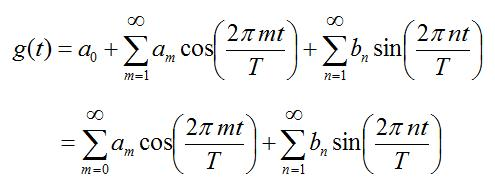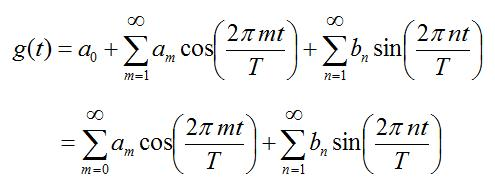

In [26]:
def Fourier(x, waveDims, *a):
    '''Function to calculate Fourier Series for array of coefficence a'''
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    
    fs = waveAmplitude/2*np.copy(x)**0 
    
    for k in range(len(a)):
        fs += a[k]*np.cos((2*np.pi*k*x)/waveLength) 
        
    return fs

In [27]:
def FWHM_Volume_Fourier(forceContour, NrackPos, X0, Nf, Ni, Nmax, indentorRadius,  waveDims):
    '''
    Calculate Fourier series components, Full Width Half Maxima and Volume for Force Contours of varying reference force using splines
    
        Parameters:          
            forceContour (arr)      - 2D Array of coordinates for contours of constant force given by reference force across scan positons 
                                      for all indentor and reference force [Nf,Ni, Nb, [x,z]] (With mask applied).
            NrackPos (arr)          - Array of initial scan positions for each indenter [Ni, Nb, [x, z]] 
            X0 (arr)                - Array of x positions along the scan
            Nf                      - Number if reference force values
            Ni                      - Number if indentor radii/ values
            Nmax (int)              - Maximum number of terms in fourier series of force contour 
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [wavelength, amplitude, width, Number of oscilations/ groups in wave] 

        Return:
            FWHM (arr)         - Array of full width half maxima of force contour for corresponding indentor and reference force [Nf,Ni]
            Volume (arr)       - Array of volume under force contour for corresponding indentor and reference force [Nf,Ni]
            A (arr)            - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
    '''
    
   #  ----------------------------------------------Calculate Volume and Fourier-----------------------------------------------------  
    # Intialise arrays for to store volume, FWHM and Fourier Series component A, for each indentor size and reference forces
    FWHM, Volume, A = np.zeros([Nf+1, Ni]), np.zeros([Nf+1, Ni]), np.zeros([Nf+1, Ni, Nmax])     
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims

    # Loop  for each indentor size and reference forces, using contours to assess volume 
    for n in range(Ni):
        # --------------------Set first values as hardsphere boundary for each fwhm and volume --------------------------------------- 
        Fx, Fz = NrackPos[n,:,0], NrackPos[n,:,1]
        # Connect contour points smoothly with a spline
        forceSpline = UnivariateSpline(Fx, Fz, s = 0.01) 

        A[0,n], pcov = curve_fit(lambda x, *a: Fourier(x, waveDims, *a), X0, forceSpline(X0), p0 =tuple(np.zeros(Nmax)))
        Volume[0,n] = forceSpline.integral(-waveDims[0]/2, 0) 
        FWHM[0,n] = abs( -waveLength/2 - UnivariateSpline(Fx, Fz - (Fz.min() + Fz.max())/2, s = 1).roots()[0]) 
        
        
        # -------------------------------------Set fwhm and volume values for each force contour--------------------------------------
        for m  in range(Nf):
            
            # Extract xz compontents of force contour - compressed removees masked values
            Fx, Fz = forceContour[m,n,:,0].compressed(), forceContour[m,n,:,1].compressed()
            
            # Use try loop to avoid error for contours that cannot produce splines  
            try: 
                # Half maxima can be calculated by finding roots of spline that is tanslated vertically so half beneath x axis
                FWHM[m+1,n] = abs( -waveLength/2 - UnivariateSpline(Fx, Fz - (Fz.min() + Fz.max())/2, s = 1).roots()[0]) 
            except:
                None 
                
            try:            
                # Connect contour points smoothly with a spline, can fail, use try to avoid code breaking
                forceSpline = UnivariateSpline(Fx, Fz-Fz.min(), s = 0.01)  
            except:
                None     
            else:
                # Volume can be found by integrating contour spline over bounds
                Volume[m+1,n] = forceSpline.integral(-waveDims[0]/2, 0) 
                # Calculate Fourier components
                A[m+1,n], pcov = curve_fit(lambda x, *a: Fourier(x, waveDims, *a), X0, forceSpline(X0)+Fz.min(), p0 =tuple(np.zeros(Nmax)))
                
    return  FWHM, Volume, A

#### Postprocessing

In [28]:
def Postprocessing(TotalU2, TotalRF, NrackPos, Nb, Nt, Nmax, courseGrain, refForces, indentorRadius, waveDims, elasticProperties, **kwargs):
    '''
    Calculate a 2D force heatmap produced from simulation over the xz domain.
    
        Parameters:          
            TotalU2 (arr)           - Array of indentors y displacement in time over scan position and  for all indenter [Ni, Nb, Nt]
            TotalRF (arr)           - Array of reaction force in time on indentor reference point over scan position  and for all indenter [Ni, Nb, Nt]
            NrackPos (arr)          - Array of initial scan positions for each indenter [Ni, Nb, [x, z]] 
            Nb (int)                - Number of scan positions along x axis of base
            Nt (int)                - Number of time steps
            Nmax (int)              - Maximum number of terms in fourier series of force contour 
            courseGrain (float)     - Width of bins that subdivid xz domain of raster scanning/ spacing of the positions sampled over
            refForces (arr)         - Array of threshold force to evaluate indentation contours at (pN)
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [wavelength, amplitude, width, Number of oscilations/ groups in wave] 
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            
        Return:
            X (arr)            - 1D array of postions over x domain of scan positions
            Z (arr)            - 1D array of postions over z domain of scan positions, discretised into bins of courseGrain value
            forceGrid (arr)    - 2D Array of force heatmap over xz domain of scan i.e. grid of xz positions with associated force 
                                 for all indentors and reference force [Nf, Ni, Nb, Nz] (With mask applied). 
            forceContour (arr) - 2D Array of coordinates for contours of constant force given by reference force across scan positons 
                                 for all indentor and reference force [Nf,Ni, Nb, [x,z]] (With mask applied).
            FWHM (arr)         - Array of full width half maxima of force contour for corresponding indentor and reference force [Nf,Ni]
            Volume (arr)       - Array of volume under force contour for corresponding indentor and reference force [Nf,Ni]
            A (arr)            - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
            E_hertz (arr)      - Array of fitted elastic modulus value over scan positions for each indentor [Ni,Nb]
            F (arr)            - Array of interpolated force values over xz grid for all indentors and reference force [Ni, Nb, Nz] 
    '''
    #  ------------------------------------------Initialise  Variables for force grid------------------------------------------------  
    Nf = len(refForces)
    Ni = len(indentorRadius)
    
    # Convert indentation data to indentor Y displacement and discretise values into bins of width given by course grain value
    zIndentor = (TotalU2 + NrackPos[:,:,1, None])
    U2 = courseGrain*np.round(zIndentor/courseGrain)    
    
    # Set X arrays of scan positions
    X = NrackPos[0,:,0]
    
    # Produce Y arrays over all Y domain of indentor position for all indentors
    Z = np.round( np.arange( U2.min(initial=0), U2.max() + courseGrain, courseGrain )*10)/10 
    

    #  -----------------------------------------------------Set force grid and force contour-----------------------------------------
    # Intialise arrays for all indentor size and reference forces
    forceContour, forceContourmask = np.zeros([Nf, Ni , Nb, 2]),     np.zeros([Nf, Ni , Nb, 2])
    forceGrid,    forceGridmask    = np.zeros([Nf, Ni, Nb, len(Z)]), np.zeros([Nf, Ni, Nb, len(Z)])
    
    # Set force grid and force contour for each indentor and refence force 
    for m  in range(Nf):
        for n in range(Ni):
            forceGrid[m,n],    forceGridmask[m,n]    = ForceGrid2D(    X, Z, U2[n], TotalRF[n], NrackPos[n], courseGrain)
            forceContour[m,n], forceContourmask[m,n] = ForceContour2D(zIndentor[n], TotalRF[n], NrackPos[n], refForces[m])
        
    
    # Mask force grid excluding postions with no indentation data [Nx,Nz] and mask force contour for zero values in which below reference force 
    forceGrid    = np.ma.masked_array(forceGrid, mask=forceGridmask)   
    forceContour = np.ma.masked_array(forceContour, mask=forceContourmask) 
    
 
    #  --------------------------------------Calculate Hertz fit and interpolate force from the fit---------------------------------
    # Initialise grid arrays over xz domain
    X0 = np.linspace(-waveDims[0]/2, 0, 250)
    Z0 = np.linspace(Z[0], waveDims[1], 250)
    Xgrid, Zgrid = np.meshgrid(X0,Z0)   
    
    # Initialise array holding Fitted Elastic modulus and Interpolated force    
    E_hertz   = np.zeros([Ni,Nb,Nt])
    F = np.zeros([Ni, len(X0), len(Z0)])
    
    # For each indentor calculate interpolated force heat maps
    for n, rIndentor in enumerate(indentorRadius):
        F[n], E_hertz[n] = ForceInterpolation(Xgrid, Zgrid, TotalU2[n], TotalRF[n], NrackPos[n], rIndentor, elasticProperties, Nt)
        
        
   #  ----------------------------------------------Calculate Volume and Fourier-----------------------------------------------------  
    # Intialise arrays for to store volume, FWHM and Fourier Series component A, for each indentor size and reference forces
    FWHM, Volume, A =  FWHM_Volume_Fourier(forceContour, NrackPos, X0, Nf, Ni, Nmax, indentorRadius, waveDims)
    
    # Mask values equal to zero
    FWHM   = np.ma.masked_equal(FWHM, 0)            
    Volume = np.ma.masked_equal(Volume, 0)
        
    return X, Z, forceContour, forceGrid, Volume, FWHM, A, E_hertz, F

### Simulation Function
Final simulation function

In [29]:
def AFMSimulation(remote_server, wrkDir, localPath, abqCommand, fileName, subData, 
                  indentorType, indentorRadius, theta_degrees, tip_length, indentionDepths, waveDims, 
                  refForces, courseGrain, Nmax, binSize, clearance, meshSurface, meshIndentor, 
                  timePeriod, timeInterval, elasticProperties, **kwargs):
    '''
    Final function to automate simulation. User inputs all variables and all results are outputted. The user gets a optionally get a surface plot of scan positions.
    Produces a heatmap of the AFM image, and 3D plots of the sample surface for given force threshold.
    
        Parameters:
            remote_server (list)    - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            wrkDir (str)            - Working directory extension
            localPath (str)         - Path to local file/directory
            abqCommand (str)        - Abaqus command to execute and run script
            fileName (str)          - Base File name for abaqus input files
            subData (str)           - Data for submission to serve queue [walltime, memory, cpus]
            
            indentorType (str)      - String defining indentor type (Spherical or Capped)
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            theta_degrees (float)   - Principle conical angle from z axis in degrees
            tip_length (float)      - Total cone height
            indentionDepths (arr)   - Array of maximum indentation depth into surface 
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [wavelength, amplitude, width, Number of oscilations/ groups in wave] 
            
            refForces (float)       - Threshold force to evaluate indentation contours at, mimics feedback force in AFM (pN)
            courseGrain (float)     - Width of bins that subdivid xz domain of raster scanning/ spacing of the positions sampled over
            Nmax (int)              - Maximum number of terms in fourier series of force contour 
            binSize (float)         - Width of bins that subdivid xz domain during raster scanning/ spacing of the positions sampled over
            clearance (float)       - Clearance above molecules surface indentor is set to during scan
            meshSurface (float)     - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m)
            meshIndentor (float)    - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m) 
            timePeriod(float)       - Total time length for ABAQUS simulation/ time step (T)
            timeInterval(float)     - Time steps data sampled over for ABAQUS simulation/ time step (dt)
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
                Submission ('serial'/ 'paralell') - Type of submission, submit pararlell scripts or single serial script for scan locations {Default: 'serial'}
                Main (bool)         - If false skip preprocessing step of simulation {Default: True}
                SurfacePlot (bool) - If false skip surface plot of biomolecule and scan positions, set as indenter radius you wish to plot {Default: False}
                Queue (bool)       - If false skip queue completion step of simulation {Default: True}
                Analysis (bool)    - If false skip odb analysis step of simulation {Default: True}
                Retrieval (bool)   - If false skip data file retrivial from remote serve {Default: True}
                Compile(int)       - If passed, simulation data is compiled from seperate sets of simulations in directory in remote server to combine 
                                     complete indentations. Value is set as int representing the range of directories to compile from (directories must have 
                                     same root naming convention with int denoting individual directories)                     - 
                Postprocess (bool) - If false skip postprocessing step to produce AFM image from data {Default: True}
                DataPlot (bool)    - If false skip scatter plot of simulation data {Default: True}
                Symmetric          - If false skip postprocessing step to produce AFM image from data {Default: True}
                
        Returns:
            X (arr)            - 1D array of postions over x domain of scan positions, discretised into bins of courseGrain value [Nx]
            Z (arr)            - 1D array of postions over z domain of scan positions, discretised into bins of courseGrain value [Nz]
            TotalU2 (arr)      - Array of indentors z displacement in time over scan position and  for all indenter [Ni, Nb, Nt]
            TotalRF (arr)      - Array of reaction force in time on indentor reference point over scan position  and for all indenter [Ni, Nb, Nt]
            NrackPos (arr)     - Array of initial scan positions for each indenter [Ni, Nb, [x, z]] 
            forceGrid (arr)    - 2D Array of force heatmap over xz domain of scan i.e. grid of xz positions with associated force [Nx,Nz] (With mask applied). 
            forceContour (arr) - 2D Array of coordinates for contours of constant force given by reference force across scan positons (With mask applied).
            FWHM (arr)         - Array of full width half maxima of force contour for corresponding indentor and reference force [Nf,Ni]
            Volume (arr)       - Array of volume under force contour for corresponding indentor and reference force [Nf,Ni]
            A (arr)            - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
            E_hertz (arr)      - Array of fitted elastic modulus value over scan positions for each indentor [Ni,Nb]
            F (arr)            - Array of interpolated force values over xz grid for all indentors and reference force [Ni, Nb, Nz] 
    '''
    # Set intial time
    T0 = time.time()
        
    #  -----------------------------------------------------Main Simulations------------------------------------------------------  
    if 'Main' not in kwargs.keys() or kwargs['Main'] == True:                
        t0 = time.time()
        
        # For each indentor radius prdoduce main simulation and submit
        for index, rIndentor in enumerate(indentorRadius): 
            print('Indentor Radius - ', rIndentor)
               
            #  ---------------------------------------Raster Scan Positions ---------------------------------------------------
            # Calculate tip geometry to create indentor and calculate scan positions over molecule for imaging
            indentionDepth = clearance + indentionDepths[index]   
                
            # Set tip dimensions
            tipDims = TipStructure(rIndentor, theta_degrees, tip_length)
            
            # Set surface dimensions
            waveLength, waveAmplitude, waveWidth, groupNum = waveDims
            Nw = 70 # int(15*groupNum+1)
            wavePos      = np.zeros([Nw, 2])
            wavePos[:,0] = np.linspace(-waveLength*groupNum/2, waveLength*groupNum/2, Nw )
            wavePos[:,1] = waveSin(wavePos[:,0], waveDims)
            
            Nb, Nt = int((waveLength/2)/(binSize) + 1), int(timePeriod/ timeInterval)+1

            # Calculate scan positions
            rackPos = ScanGeometry(indentorType, tipDims, waveDims, Nb, clearance)
                
            #  -------------------------------------------Export Variable-----------------------------------------------------
            # Set list of simulation variables and export to current directory
            variables = [timePeriod, timeInterval, binSize, indentionDepth, meshIndentor, meshSurface]
            ExportVariables(rackPos, variables, waveDims, wavePos, tipDims, indentorType, elasticProperties)

            
            #  -------------------------------------------Remote Submission---------------------------------------------------
            remotePath = wrkDir +'/IndenterRadius'+str(int(rIndentor))

            abqfiles = ('AFMtestRasterScan.py','AFMtestODBAnalysis.py')
            csvfiles = ("rackPos.csv", "variables.csv", "waveDims.csv", "wavePos.csv", "tipDims.csv", "indentorType.txt", "elasticProperties.csv")

            RemoteSubmission(remote_server, remotePath, localPath,  csvfiles, abqfiles, abqCommand, fileName, subData, rackPos, **kwargs)
   
        t1 = time.time()
        print('Main Submission Complete - ' + str(timedelta(seconds=t1-t0)) + '\n')          
        
        
    #  -------------------------------------------------Queue Status----------------------------------------------------------
    if 'Queue' not in kwargs.keys() or kwargs['Queue'] == True:
        t0 = time.time()
        print('Simulations Processing ...')

        # Wait for completion when queue is empty
        QueueCompletion(remote_server, **kwargs)

        t1 = time.time()
        print('ABAQUS Simulation Complete - '+ str(timedelta(seconds=t1-t0)) + '\n' )
         
            
    #  -------------------------------------------ODB Analysis Submission----------------------------------------------------
    if 'Analysis' not in kwargs.keys() or kwargs['Analysis'] == True:
        t0 = time.time()
        print('Running ODB Analysis...')
        
        # For each indentor radius
        for index, rIndentor in enumerate(indentorRadius):
            print('Indentor Radius:', rIndentor) 
            
            # ODB analysis script to run, extracts data from simulation and sets it in csv file on server
            script     = 'AFMtestODBAnalysis.py'
            remotePath = wrkDir + '/IndenterRadius'+str(int(rIndentor))
            
            RemoteCommand(remote_server, script, remotePath, abqCommand, **kwargs)
        
        t1 = time.time()
        print('ODB Analysis Complete - ' + str(timedelta(seconds=t1-t0)) + '\n' )

        
    #  -----------------------------------------------File Retrieval----------------------------------------------------------
    if 'Retrieval' not in kwargs.keys() or kwargs['Retrieval'] == True:
        t0 = time.time()
        print('Running File Retrieval...')
        
        # Retrieve variables used for given simulation (in case variables redefined when skip kwargs used) 
        dataFiles = ('U2_Results.csv','RF_Results.csv', 'rackPos.csv')
        csvfiles  = ( "rackPos.csv", "variables.csv","waveDims.csv", "tipDims.csv")

        variables, TotalU2, TotalRF, NrackPos = DataRetrieval(remote_server, wrkDir, localPath, csvfiles, dataFiles, indentorRadius, **kwargs)

        # Export simulation data so it is saved in current directory for future use (save as a 2d array instead of 3d)
        np.savetxt("data"+os.sep+"variables.csv", variables, fmt='%s', delimiter=",")
        np.savetxt("data"+os.sep+"TotalU2.csv", TotalU2.reshape(TotalU2.shape[0], -1), fmt='%s', delimiter=",")
        np.savetxt("data"+os.sep+"TotalRF.csv", TotalRF.reshape(TotalRF.shape[0], -1), fmt='%s', delimiter=",")
        np.savetxt("data"+os.sep+"NrackPos.csv", NrackPos.reshape(NrackPos.shape[0], -1), fmt='%s', delimiter=",")

        t1 = time.time()
        print('File Retrevial Complete' + '\n')  

        
    #  -------------------------------------------------- Post-Processing-------------------------------------------------------
    if  'Postprocess' not in kwargs.keys() or kwargs['Postprocess'] == True:
        
        t0 = time.time()
        print('Running Postprocessing...')
        
        # Check if simulation files are accessible in curent directory to use if pre=processing skipped
        try:
            variables, waveDims, rackPos  = ImportVariables()
            waveLength, waveAmplitude, waveWidth, groupNum = waveDims
            timePeriod, timeInterval, binSize, indentionDepth, meshIndentor, meshSurface = variables
            Nb, Nt = int((waveLength/2)/(binSize) + 1), int(timePeriod/ timeInterval)+1

            # Load saved simulation data and reshape as data sved as 2d array,  true shape is 3d
            TotalU2  = np.array(np.loadtxt("data"+os.sep+'TotalU2.csv', delimiter=",")).reshape(len(indentorRadius), Nb, Nt)
            TotalRF  = np.array(np.loadtxt("data"+os.sep+'TotalRF.csv', delimiter=",")).reshape(len(indentorRadius), Nb, Nt)    
            NrackPos = np.array(np.loadtxt("data"+os.sep+'NrackPos.csv', delimiter=",")).reshape(len(indentorRadius), Nb, 2)  

        # If file missing prompt user to import/ produce files 
        except:
            print('No Simulation files available, run preprocessing or import data' + '\n')
        
        
        #  ---------------------------------------------------- Data-Processing---------------------------------------------------     
        # Visualise data if set in kwargs
        if 'DataPlot' in kwargs.keys(): 
            n =  kwargs['DataPlot']
            DataPlot(NrackPos, TotalU2, TotalRF, Nb, Nt, n)
              
        # Process simulation data to produce heat map, analyse force contours, full width half maximum, volume and youngs modulus
        X, Z, forceContour, forceGrid, Volume, FWHM, A, E_hertz, F = Postprocessing(TotalU2, TotalRF, NrackPos, Nb, Nt, Nmax, courseGrain, refForces, indentorRadius, 
                                                                              waveDims, elasticProperties, **kwargs)
        
        t1 = time.time()
        print('Postprocessing Complete' + '\n')
        
        
        # Return final time of simulation and variables
        T1 = time.time()
        print('Simulation Complete - ' + str(timedelta(seconds=T1-T0)) )
        return X, Z, TotalU2, TotalRF, NrackPos, forceContour, forceGrid, Volume, FWHM, A, E_hertz, F
    
    else:
        # Return final time of simulation
        T1 = time.time()
        print('Simulation Complete - ' + str(timedelta(seconds=T1-T0)) )
        return None, None, None, None, None, None, None, None, None, None, None, None

## Plot Functions
Code to plot results of the simulation

### Manuscript Contour Plot

In [30]:
def ContourPlotMan(X, Z, rackPos, forceGrid, forceContour, indentorRadius, clearance, A, N, waveDims, theta_degrees, tip_length, binSize, elasticProperties, normalizer, 
                   maxRF, contrast, n0, n1, n2):
    ''' 
    Function to plot a 2D force heatmap produced from simulation over the xz domain for single indenter and refereance force.
    
        Parameters:          
            X (arr)                 - 1D array of x coordinates over scan positions 
            Z (arr)                 - 1D array of z coordinates over scan positions 
            rackPos (arr)           - Array of initial scan positions for indenter [Nb, [x, z] ] 
            forceGrid (arr)         - 2D Array of force grid of xz positions 
            forceContour( arr)      - 2D Array of coordinates for contours of constant force given by reference force 
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            clearance(float)        - Clearance above molecules surface indentor is set to during scan
            A (arr)                 - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
            N (int)                 - Number of fourier series terms included in fit
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [width, height, depth]
            theta_degrees (float)   - Principle conical angle from z axis in degrees
            tip_length (float)      - Total cone height
            binSize (float)         - Width of bins that subdivid xz domain during raster scanning/ spacing of the positions sampled over
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            normalizer (obj)        - Normalisation of cmap
            maxRF (float)           - Maximum Force value
            contrast (float)        - Contrast between high and low values in AFM heat map (0-1)
    '''
    # -----------------------------------------------------------Set Variable---------------------------------------------------------      
    # Set material properties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2) 
    # Tip variables
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = TipStructure(indentorRadius[n1], theta_degrees, tip_length)
    # Set constant to normalise dimensionaless forces and colour map
    F_dim = (E_eff*rIndentor**2)    
    colormap = mpl.colormaps.get_cmap('coolwarm')
    colormap.set_bad('grey') 
    
    # Surface variables
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    # Increase padding to add above surface
    hPadding = 1
    # Produce spherical tip with polar coordinates
    x = np.linspace(-waveLength/2,waveLength/2, 100)    

    # ---------------------------------------------------------Plots------------------------------------------------------------------- 
    # Plot of force heatmaps using imshow to directly visualise 2D array
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/3, linewidth/3)) 
       
    # ----------------------------------------------------2D Plots Indentor 1--------------------------------------------------------     
    # 2D heat map plot without interpolation, append two together to produce whole wavelength
    im = ax.imshow(np.ma.append(forceGrid[n1][::-1],forceGrid[n1], axis=0).T/F_dim, origin= 'lower', cmap=colormap, interpolation='bicubic', norm= normalizer,
                      extent = (-1/2, 1/2, Z[0]/waveLength, Z[-1]/waveLength), interpolation_stage = 'rgba')
    
    
    # Plot fourier series fit for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(x/waveLength, waveSin(x+waveLength/2, waveDims)/waveLength, ':',                  color = 'w', lw = 1, label = 'Surface boundary') 
    ax.plot(x/waveLength, Fourier(x+waveLength/2, waveDims,*A[n1,:N])/waveLength,                color = 'r', lw = 1, label = 'Fitted Contour')

    ax.plot((rackPos[n1,:,0]+waveLength/2)/waveLength, (rackPos[n1,:,1]-clearance)/waveLength, ':', color = 'r', lw = 1, label = 'Hard Sphere boundary')
    ax.plot(rackPos[n1,:,0]/waveLength, (rackPos[n1,:,1][::-1]-clearance)/waveLength,':',           color = 'r', lw = 1, label = 'Hard Sphere boundary')
    

    # Plot indentor geometry
    ax.plot((x)/waveLength, (Fconical(x, 0, r_int, z_int, theta, rIndentor, tip_length)+rackPos[n1,0,1])/waveLength, color = 'w', lw = 1, label = 'Indentor boundary') 
    
    
    # Add 0 values in image for region above surface
    ax.imshow(np.zeros([10,10]), origin= 'lower', cmap='coolwarm', interpolation='bicubic', norm= normalizer, 
              extent = (-1/2, 1/2, waveAmplitude/waveLength, ((1+hPadding)*waveAmplitude)/waveLength) ) 

    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'$x/\lambda$')
    ax.set_ylabel(r'$z/\lambda$', rotation=0,  labelpad = 15)
    ax.set_xlim(-1/2, 1/2)
    ax.set_ylim(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength)
    ax.axes.set_aspect('equal')
    ax.set_yticks(np.round(20*np.linspace(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength, 3))/20)
    ax.tick_params(axis='x', labelrotation=0)

    # -----------------------------------------------------Change Indentor 2-------------------------------------------------------- 
    # Tip variables
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = TipStructure(indentorRadius[n2], theta_degrees, tip_length)  
    # Set constant to normalise dimensionaless forces
    F_dim = (E_eff*rIndentor**2)
    
    
    # ----------------------------------------------------2D Plots Indentor 2-------------------------------------------------------- 
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/3, linewidth/3)) 
    # 2D heat map plot without interpolation, append two together to produce whole wavelength
    im = ax.imshow(np.ma.append(forceGrid[n2][::-1],forceGrid[n2], axis=0).T/F_dim, origin= 'lower', cmap=colormap, interpolation='bicubic', norm= normalizer,
                      extent = (-1/2, 1/2, Z[0]/waveLength, Z[-1]/waveLength), interpolation_stage = 'rgba')
    
    # Plot fourier series fit for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(x/waveLength, waveSin(x+waveLength/2, waveDims)/waveLength, ':',                  color = 'w', lw = 1, label = 'Surface boundary') 
    ax.plot(x/waveLength, Fourier(x+waveLength/2, waveDims,*A[n2,:N])/waveLength,                color = 'r', lw = 1, label = 'Fitted Contour')

    ax.plot((rackPos[n2,:,0]+waveLength/2)/waveLength, (rackPos[n2,:,1]-clearance)/waveLength, ':', color = 'r', lw = 1, label = 'Hard Sphere boundary')
    ax.plot(rackPos[n2,:,0]/waveLength, (rackPos[n2,:,1][::-1]-clearance)/waveLength,':',           color = 'r', lw = 1, label = 'Hard Sphere boundary')
    

    # Plot indentor geometry
    ax.plot((x)/waveLength, (Fconical(x, 0, r_int, z_int, theta, rIndentor, tip_length)+rackPos[n2,0,1])/waveLength, color = 'w', lw = 1, label = 'Indentor boundary') 
    
    # Add 0 values in image for region above surface
    ax.imshow(np.zeros([10,10]), origin= 'lower', cmap='coolwarm', interpolation='bicubic', norm= normalizer, 
              extent = (-1/2, 1/2, waveAmplitude/waveLength, ((1+hPadding)*waveAmplitude)/waveLength) ) 

    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'$x/\lambda$')
    # ax.set_ylabel(r'$\frac{z}{\lambda}$', rotation=0,  labelpad = 15)
    ax.set_xlim(-1/2, 1/2)
    ax.set_ylim(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength)
    ax.axes.set_aspect('equal')
    ax.set_yticks(np.round(20*np.linspace(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength, 3))/20)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(labelleft=False)  
    
    # ------------------------------------------------Plot color bar ------------------------------------------------------------
    cbar= fig.colorbar(im, ax= ax , orientation = 'vertical', fraction=0.08, pad=0.03)
    cbar.set_label(r'$\frac{F}{E*R^2}$', rotation=0)
    cbar.set_ticks(np.round(10*np.array([0, maxRF*0.25**(1/0.45), maxRF*0.75**(1/0.45), maxRF]))/10)
    cbar.ax.yaxis.set_label_coords(4, 0.6)
    
    
    #  ----------------------------------------------Raster Scan positions ------------------------------------------------------    
    Nw = 70 # int(15*groupNum+1)
    Nb = int((waveLength/2)/(binSize) + 1)
    
    tipDims =  TipStructure(4, theta_degrees, tip_length)
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    
    wavePos      = np.zeros([Nw, 2])
    wavePos[:,0] = np.linspace(-waveLength/2, waveLength/2, Nw )
    wavePos[:,1] = waveSin(wavePos[:,0], waveDims)

    # Raster scan grid positions for spherical and capped tip 
    rackPosCone = ScanGeometry('Capped', tipDims, waveDims, Nb, clearance)/waveLength
    # Set index for scan position to plot tip at
    i,j = 0,-3

    # Produce array for the x extent
    x = np.linspace(-waveLength, 0, 1000)/waveLength
    X = np.linspace(-r_top, r_top, 1000)
    
    # Produce spherical tip with polar coordinates
    x1 = rIndentor*np.cos(np.linspace(-np.pi, np.pi, 1000))/waveLength
    y1 = rIndentor*np.sin(np.linspace(-np.pi, np.pi, 1000))/waveLength
    
    #  --------------------------------------------------Plot Setup ---------------------------------------------------------    
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/3, linewidth/3)) 
    # Plot spherical and conical scan position as points
    ax.plot(rackPosCone[:,0] + 0.5, rackPosCone[:,1]+Z[0]/waveLength, '.', ms=3, color = 'r')
    # Plot lines for wave base and points used to define it in abaqus wavePos
    ax.plot(x + 0.5, waveSin(x*waveLength, waveDims)/waveLength+Z[0]/waveLength, 'k')

    # Plot the geometry of spherical and conical tip at index i
    ax.plot(X/waveLength + rackPosCone[i,0] + 0.5, Fconical(X, 0, r_int, z_int, theta, rIndentor, tip_length)/waveLength + rackPosCone[i,1]+Z[0]/waveLength, color=  '#5a71ad')
    ax.plot(x1 + rackPosCone[i,0] + 0.5, y1+rIndentor/waveLength + rackPosCone[i,1]+Z[0]/waveLength, ':', color = '#fc8535')
    
    # Plot the geometry of spherical and conical tip at index j
    ax.plot(X/waveLength + rackPosCone[j,0] + 0.5,  Fconical(X, 0, r_int, z_int, theta, rIndentor, 8)/waveLength + rackPosCone[j,1]+Z[0]/waveLength, color=  '#5a71ad')
    ax.plot(x1 + rackPosCone[j,0] + 0.5, y1 + rIndentor/waveLength + rackPosCone[j,1]+Z[0]/waveLength, ':', color = '#fc8535')
    
    # Set axis labels to create desired layout
    ax.set_xlim(-0.5, 0.7)
    ax.set_ylim(Z[0]/waveLength-0.1, ((1+hPadding)*waveAmplitude)/waveLength)
    ax.axes.set_aspect('equal')
    # ax.set_axis_off()
    
    # # Make axis invisible    
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.tick_params(colors='white')
    # Annotating Diagram
    ax.text(0, -0.25+Z[0]/waveLength, r'$\lambda$')
    ax.text(-rIndentor/(2*waveLength)-0.02, (waveAmplitude + rIndentor+Z[0])/waveLength+0.05, 'R', color = '#fc8535')
    
    plt.rcParams['font.size'] = 8

    ax.annotate('', color = '#fc8535',
                xy=(-rIndentor/waveLength, (waveAmplitude + rIndentor + Z[0])/waveLength ), xycoords='data',
                xytext=(0.025, (waveAmplitude + rIndentor + Z[0])/waveLength ), textcoords='data',
                arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='#fc8535'))
    
    ax.annotate('', xy=(-0.5, -0.25), xycoords='data', 
                xytext=(0.5, -0.25), textcoords='data',
                arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='k'))   
        
    plt.rcParams['font.size'] = 13
    plt.show()

### Illustrative Surface Plot

In [31]:
def SurfacePlot(rackPos, Nb, waveDims, wavePos, tipDims, binSize, clearance):
    ''' 
    Plot the surfaces and scan positions to visualise and check positions. 
    
        Parameters:
            rackPos (arr)      - Array of coordinates [x,z] of scan positions to image biomolecule  
            Nb (int)           - Number of scan positions along x axis of base
            waveDims (list)    - Geometric parameters for defining base/ substrate structure [Wavelength, Amplitude, Width, Number of oscilations/ groups in wave ] 
            wavePos            - Positions on wave used to define spline in ABAQUS
            tipDims (list)     - Geometric parameters for defining capped tip structure  
            binSize (float)    - Width of bins that subdivid xz domain during raster scanning/ spacing of the positions sampled over
            clearance (float)  - Clearance above molecules surface indentor is set to during scan
    '''
    
    #  ----------------------------------------------Raster Scan positions ------------------------------------------------------
    # Set tip and wave dimensional variables 
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    
    # Raster scan grid positions for spherical and capped tip 
    rackPosSphere = ScanGeometry('Spherical', tipDims, waveDims, Nb, clearance)
    rackPosCone = ScanGeometry('Capped', tipDims, waveDims, Nb, clearance)

    # Set index for scan position to plot tip at
    i,j = 0,-1

    # Produce array for the x extent
    x = np.linspace(-2*waveLength, waveLength, 1000)
    X = np.linspace(-r_top, r_top, 1000)
    
    # Produce spherical tip with polar coordinates
    x1 = rIndentor*np.cos(np.linspace(-np.pi, np.pi, 1000))
    y1 = rIndentor*np.sin(np.linspace(-np.pi, np.pi, 1000))
    
    
    #  --------------------------------------------------Plot Points ----------------------------------------------------------
    # Create figure for scan positions
    fig, ax = plt.subplots(1,1, figsize= (linewidth/2, linewidth/2 ))
    
    # Plot spherical and conical scan position as points
    # ax.plot(rackPosCone[:,0], rackPosCone[:,1], '.', color = 'r')
    # Plot lines for wave base and points used to define it in abaqus wavePos
    ax.plot(x, waveSin(x, waveDims), 'k')

    # Plot the geometry of spherical and conical tip at index i
    ax.plot(X+rackPosCone[i,0], Fconical(X, 0, r_int, z_int, theta, rIndentor, tip_length)+rackPosCone[i,1], color=  '#5a71ad')
    ax.plot(x1+rackPosCone[i,0], y1+rIndentor+rackPosCone[i,1], ':', color = '#fc8535')
    
    # Plot the geometry of spherical and conical tip at index j
    ax.plot(X+rackPosCone[j,0], Fconical(X, 0, r_int, z_int, theta, rIndentor, 8)+rackPosCone[j,1], color=  '#5a71ad')
    ax.plot(x1+rackPosCone[j,0], y1+rIndentor+rackPosCone[j,1], ':', color = '#fc8535')
    
    # Set axis labels to create desired layout
    ax.set_xlabel(r'$x/\lambda$', labelpad = 5, color='white')
    ax.set_xlim(-2*waveLength, waveLength)
    ax.set_ylim(-3.5, ((2)*waveAmplitude))
    ax.axes.set_aspect('equal')
    ax.legend(frameon=False, ncol=3, fontsize=11, loc=[0,0.8], labelspacing=0.2)
    
    # Place axis on right for desired spacing
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    # Make axis invisible    
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.tick_params(colors='white')

    # Annotating Diagram
    ax.text(-waveLength/2-rIndentor/2-0.3, waveAmplitude + rIndentor + 0.8, 'R', color = '#fc8535')
    ax.text(-waveLength/2, 0.3, r'$\lambda$')   
    
    plt.rcParams['font.size'] = 8
    ax.annotate('', color = '#fc8535',
                xy=(-waveLength/2+1, waveAmplitude+rIndentor), xycoords='data',
                xytext=(-waveLength/2-rIndentor, waveAmplitude+rIndentor), textcoords='data',
                arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='#fc8535'))
    ax.annotate('', xy=(-waveLength, -0.4), xycoords='data', 
                xytext=(0, -0.4), textcoords='data',
                arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='k'))
    plt.rcParams['font.size'] = 13
    plt.show()

### Contour Plot

#### Interpolate

In [32]:
def ContourPlot(X, Z, rackPos, forceGrid, forceContour, refForce, clearance, A, N, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast):
    ''' 
    Function to plot a 2D force heatmap produced from simulation over the xz domain for single indenter and refereance force.
    
        Parameters:          
            X (arr)                 - 1D array of x coordinates over scan positions 
            Z (arr)                 - 1D array of z coordinates over scan positions 
            rackPos (arr)           - Array of initial scan positions for indenter [Nb, [x, z] ] 
            forceGrid (arr)         - 2D Array of force grid of xz positions 
            forceContour( arr)      - 2D Array of coordinates for contours of constant force given by reference force 
            refForce (float)        - Threshold force to evaluate indentation contours at 
            clearance(float)        - Clearance above molecules surface indentor is set to during scan
            A (arr)                 - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
            N (int)                 - Number of fourier series terms included in fit
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [width, height, depth]
            tipDims (list)          - Geometric parameters for defining capped tip structure     
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            normalizer (obj)        - Normalisation of cmap
            maxRF (float)           - Maximum Force value
            contrast (float)        - Contrast between high and low values in AFM heat map (0-1)
    '''
    
    #  ----------------------------------------------------Set Variable-----------------------------------------------------      
    # Set material properties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2) 
    
    # Tip variables
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    # Surface variables
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    
    # Extract xz compontents of force contour - compressed removes masked values
    Fx, Fz = np.array(forceContour[:,0].compressed()), np.array(forceContour[:,1].compressed())    
    # Set constant to normalise dimensionaless forces
    F_dim = (E_eff*rIndentor**2)

    
    # Increase padding to add above surface
    hPadding = 1
    # Produce spherical tip with polar coordinates
    x = np.linspace(-waveLength/2,waveLength/2, 100)
    

    #  ----------------------------------------------------2D Plots--------------------------------------------------------
    # Plot of force heatmaps using imshow to directly visualise 2D array
    fig, ax = plt.subplots(1, 1, figsize = (11.69/3, 8.27/3)) 
    
    
    # 2D heat map plot without interpolation, append two together to produce whole wavelength
    im = ax.imshow(np.ma.append(forceGrid[::-1],forceGrid, axis=0).T/F_dim, origin= 'lower', cmap='coolwarm', interpolation='bicubic', norm= normalizer,
                      extent = (-1/2, 1/2, Z[0]/waveLength, Z[-1]/waveLength), interpolation_stage = 'rgba')
    
    # Plot fourier series fit for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(x/waveLength, waveSin(x+waveLength/2, waveDims)/waveLength, ':',                  color = 'w', lw = 1, label = 'Surface boundary') 
    ax.plot(x/waveLength, Fourier(x+waveLength/2, waveDims,*A[:N])/waveLength,                color = 'r', lw = 1, label = 'Fitted Contour')

    ax.plot((rackPos[:,0]+waveLength/2)/waveLength, (rackPos[:,1]-clearance)/waveLength, ':', color = 'r', lw = 1, label = 'Hard Sphere boundary')
    ax.plot(rackPos[:,0]/waveLength, (rackPos[:,1][::-1]-clearance)/waveLength,':',           color = 'r', lw = 1, label = 'Hard Sphere boundary')
    

    # Plot indentor geometry
    ax.plot((x)/waveLength, (Fconical(x, 0, r_int, z_int, theta, rIndentor, tip_length)+rackPos[0,1])/waveLength, color = 'w', lw = 1, label = 'Indentor boundary') 
    
    # Add 0 values in image for region above surface
    ax.imshow(np.zeros([10,10]), origin= 'lower', cmap='coolwarm', interpolation='bicubic', norm= normalizer, 
              extent = (-1/2, 1/2, waveAmplitude/waveLength, ((1+hPadding)*waveAmplitude)/waveLength) ) 

    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'$\frac{x}{\lambda}$')
    ax.set_ylabel(r'$\frac{z}{\lambda}$', rotation=0,  labelpad = 15)
    ax.set_xlim(-1/2, 1/2)
    ax.set_ylim(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength)
    ax.set_facecolor("grey")
    ax.axes.set_aspect('equal')
    
    # --------------------------------------------Plot color bar ----------------------------------------------------------
    cbar= fig.colorbar(im, ax= ax , orientation = 'vertical', fraction=0.035, pad=0.02)
    cbar.set_label(r'$\frac{F}{E*R^2}$', rotation=0)
    cbar.set_ticks(np.round(10*np.array([0, maxRF*0.25**(1/0.45), maxRF*0.75**(1/0.45), maxRF]))/10)
    cbar.ax.yaxis.set_label_coords(4, 0.6)       
    plt.show()

#### No Interpolate

In [33]:
def ContourPlotNI(X, Z, rackPos, forceGrid, forceContour, refForce, clearance, A, N, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast):
    ''' 
    Function to plot a 2D force heatmap produced from simulation over the xz domain for single indenter and refereance force.
    
        Parameters:          
            X (arr)                 - 1D array of x coordinates over scan positions 
            Z (arr)                 - 1D array of z coordinates over scan positions 
            rackPos (arr)           - Array of initial scan positions for indenter [Nb, [x, z] ] 
            forceGrid (arr)         - 2D Array of force grid of xz positions 
            forceContour( arr)      - 2D Array of coordinates for contours of constant force given by reference force 
            refForce (float)        - Threshold force to evaluate indentation contours at 
            clearance(float)        - Clearance above molecules surface indentor is set to during scan
            A (arr)                 - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
            N (int)                 - Number of fourier series terms included in fit
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [width, height, depth]
            tipDims (list)          - Geometric parameters for defining capped tip structure     
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            normalizer (obj)        - Normalisation of cmap
            maxRF (float)           - Maximum Force value
            contrast (float)        - Contrast between high and low values in AFM heat map (0-1)
    '''
    
    #  ----------------------------------------------------Set Variable-----------------------------------------------------      
    # Set material properties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2) 
    
    # Tip variables
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    # Surface variables
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    
    # Extract xz compontents of force contour - compressed removes masked values
    Fx, Fz = np.array(forceContour[:,0].compressed()), np.array(forceContour[:,1].compressed())    
    # Set constant to normalise dimensionaless forces
    F_dim = (E_eff*rIndentor**2)

    # Increase padding to add above surface
    hPadding = 1
    # Produce spherical tip with polar coordinates
    x = np.linspace(-waveLength/2,waveLength/2, 100)
    

    #  ----------------------------------------------------2D Plots--------------------------------------------------------
    # Plot of force heatmaps using imshow to directly visualise 2D array
    fig, ax = plt.subplots(1, 1, figsize = (11.69/3, 8.27/3)) 
    
    
    # 2D heat map plot without interpolation
    im = ax.imshow(np.ma.append(forceGrid[::-1],forceGrid, axis=0).T/F_dim, origin= 'lower', cmap='coolwarm', interpolation='none', norm= normalizer,
                      extent = (-1/2, 1/2, Z[0]/waveLength, Z[-1]/waveLength))
    
    # Plot fourier series fit for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(x/waveLength,            waveSin(x+waveLength/2, waveDims)/waveLength, ':',       color = 'w', lw = 1, label = 'Surface boundary') 
    
    ax.plot((Fx+waveLength/2)/waveLength,  Fz/waveLength, 'x', ms = 3,                        color = 'k', lw = 1, label = 'Force contour for F= {0:.3f}'.format(refForce/F_dim))  
    ax.plot(-(Fx+waveLength/2)/waveLength, Fz/waveLength, 'x', ms = 3,                        color = 'k', lw = 1, label = 'Force contour for F= {0:.3f}'.format(refForce/F_dim))  

    ax.plot((rackPos[:,0]+waveLength/2)/waveLength, (rackPos[:,1]-clearance)/waveLength, ':', color = 'r', lw = 1, label = 'Hard Sphere boundary')
    ax.plot(rackPos[:,0]/waveLength, (rackPos[:,1][::-1]-clearance)/waveLength,':',           color = 'r', lw = 1, label = 'Hard Sphere boundary')
    

    # Plot indentor geometry
    ax.plot((x)/waveLength, (Fconical(x, 0, r_int, z_int, theta, rIndentor, tip_length)+rackPos[0,1])/waveLength, color = 'w', lw = 1, label = 'Indentor boundary') 
    
    # Add 0 values in image for region above surface
    ax.imshow(np.zeros([10,10]), origin= 'lower', cmap='coolwarm', interpolation='none', norm= normalizer, 
              extent = (-1/2, 1/2, waveAmplitude/waveLength, ((1+hPadding)*waveAmplitude)/waveLength) ) 

    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'$\frac{x}{\lambda}$')
    ax.set_ylabel(r'$\frac{z}{\lambda}$', rotation=0,  labelpad = 15)
    ax.set_xlim(-1/2, 1/2)
    ax.set_ylim(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength)
    ax.set_facecolor("grey")
    ax.axes.set_aspect('equal')
        
    # --------------------------------------------Plot color bar ----------------------------------------------------------
    cbar= fig.colorbar(im, ax= ax , orientation = 'vertical', fraction=0.035, pad=0.02)
    cbar.set_label(r'$\frac{F}{E*R^2}$', rotation=0)
    cbar.set_ticks(np.round(10*np.array([0, maxRF*0.25**(1/0.45), maxRF*0.75**(1/0.45), maxRF]))/10)
    cbar.ax.yaxis.set_label_coords(4, 0.6)       
    plt.show()

#### Line

In [34]:
def LineContourPlot(X, Z, rackPos, forceContour, refForces, clearance, A, N, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast):
    ''' 
    Function to plot a 2D force contour lines produced from simulation over the xz domain for single indenter and range of reference force.
    
        Parameters:          
            X (arr)                 - 1D array of x coordinates over scan positions 
            Z (arr)                 - 1D array of z coordinates over scan positions 
            RF(arr)                 - Array of reaction force on indentor reference point
            rackPos (arr)           - Array of initial scan positions for indenter [Nb, [x, z] ]             
            forceContour( arr)      - 2D Array of coordinates for contours of constant force given by reference force 
            refForces (float)       - Threshold force to evaluate indentation contours at (pN)
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            clearance(float)        - Clearance above molecules surface indentor is set to during scan
            A (arr)                 - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
            N (int)                 - Number of fourier series terms included in fit
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [width, height, depth]
            tipDims (list)          - Geometric parameters for defining capped tip structure  
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            normalizer (obj)        - Normalisation of cmap
            maxRF (float)           - Maximum Force value
            contrast (float)        - Contrast between high and low values in AFM heat map (0-1)
    '''
    #  ----------------------------------------------------Set Variable-----------------------------------------------------      
    # Tip variables
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    # Surface variables
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims        
    
    # Set material Propeties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2) 
    # Set constant to normalise dimensionaless forces
    F_dim = (E_eff*rIndentor**2)
    
    cmap = mpl.cm.coolwarm


    
    # Produce spherical tip with polar coordinates
    x = np.linspace(-waveLength/2,waveLength/2, 100)
    # Increase padding to add above surface
    hPadding = 1
    
    #  ----------------------------------------------------2D Plots--------------------------------------------------------
    # Plot of force heatmaps using imshow to directly visualise 2D array
    fig, ax = plt.subplots(1, 1, figsize = (11.69/3, 8.27/3) )  
    
    #  --------------------------------------------------Interpolation-----------------------------------------------------      
    # Plot spline force for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(x/waveLength, waveSin(x+waveLength/2, waveDims)/waveLength, ':',                  color = 'k',                 lw = 2, label = 'Surface') 
    ax.plot((rackPos[:,0]+waveLength/2)/waveLength, (rackPos[:,1]-clearance)/waveLength, ':', color = cmap(normalizer(0)), lw = 2, label = 'Hard\nSphere')
    ax.plot(rackPos[:,0]/waveLength, (rackPos[:,1][::-1]-clearance)/waveLength,':',           color = cmap(normalizer(0)), lw = 2)
    
    for m in range(len(refForces)):
        ax.plot(x/waveLength, Fourier(x+waveLength/2, waveDims,*A[m+1,:N])/waveLength,          color = cmap(normalizer(refForces[m]/F_dim)), lw = 1 )    
    
    # Plot indentor geometry
    ax.plot((x)/waveLength, (Fconical(x, 0, r_int, z_int, theta, rIndentor, tip_length)+rackPos[0,1])/waveLength, color = 'k', lw = 1, label = 'Indentor') 

        
    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'$\frac{x}{\lambda}$')
    ax.set_ylabel(r'$\frac{z}{\lambda}$', rotation=0,  labelpad = 15)
    ax.set_xlim(-1/2, 1/2)
    ax.set_ylim(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength)
    ax.axes.set_aspect('equal')

    # --------------------------------------------Plot color bar -----------------------------------------------------------
    # plt.legend(frameon=False)
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=normalizer), fraction=0.035, pad=0.02)
    cbar.set_label(r'$\frac{F}{E*R^2}$', rotation=0)
    cbar.set_ticks(np.round(10*np.array([0, maxRF*0.25**(1/0.45), maxRF*0.75**(1/0.45), maxRF]))/10)
    cbar.ax.yaxis.set_label_coords(4, 0.6)       
    plt.show()

### Force Interpolation Plot

In [35]:
def FInterpolatePlot(X, Z, rackPos, F, clearance, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast):
    ''' 
    Function to plot a 2D force heatmap interpolated from simulation over the xz domain.
    
        Parameters:          
            X (arr)                 - 1D array of x coordinates over scan positions 
            Z (arr)                 - 1D array of z coordinates over scan positions 
            rackPos (arr)           - Array of initial scan positions for indenter [Nb, [x, z] ] 
            F (arr)                 - Array of interpolated force values over xz grid for all indentors and reference force [Ni, Nb, Nz] 
            clearance(float)        - Clearance above molecules surface indentor is set to during scan
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [width, height, depth]
            tipDims (list)          - Geometric parameters for defining capped tip structure     
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            normalizer (obj)        - Normalisation of cmap
            maxRF (float)           - Maximum Force value
            contrast (float)        - Contrast between high and low values in AFM heat map (0-1)
    '''
    
    #  ----------------------------------------------------Set Variable-----------------------------------------------------      
    # Set material properties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2) 
    
    # Tip variables
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    # Surface variables
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims
    
    # Set constant to normalise dimensionaless forces
    F_dim = (E_eff*rIndentor**2)

    
    # Increase padding to add above surface
    hPadding = 1
    
    # Produce spherical tip with polar coordinates
    x = np.linspace(-waveLength/2,waveLength/2, 100)
    

    #  ----------------------------------------------------2D Plots--------------------------------------------------------
    # Plot of force heatmaps using imshow to directly visualise 2D array
    fig, ax = plt.subplots(1, 1, figsize = (11.69/3, 8.27/3)) 
    
    
    # 2D heat map plot without interpolation, append two together to produce whole wavelength
    im = ax.imshow(np.ma.append(F.T[::-1],F.T, axis=0).T/F_dim, origin= 'lower', cmap='coolwarm', interpolation='bicubic', norm= normalizer,
                   extent = (-1/2, 1/2, Z[0]/waveLength, Z[-1]/waveLength), interpolation_stage = 'rgba')
    
    # Plot fourier series fit for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(x/waveLength, waveSin(x+waveLength/2, waveDims)/waveLength, ':',                  color = 'w', lw = 1, label = 'Surface boundary') 
    ax.plot((rackPos[:,0]+waveLength/2)/waveLength, (rackPos[:,1]-clearance)/waveLength, ':', color = 'r', lw = 1, label = 'Hard Sphere boundary')
    ax.plot(rackPos[:,0]/waveLength, (rackPos[:,1][::-1]-clearance)/waveLength,':',           color = 'r', lw = 1, label = 'Hard Sphere boundary')
    

    # Plot indentor geometry
    ax.plot((x)/waveLength, (Fconical(x, 0, r_int, z_int, theta, rIndentor, tip_length)+rackPos[0,1])/waveLength, color = 'w', lw = 1, label = 'Indentor boundary') 

    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'$\frac{x}{\lambda}$')
    ax.set_ylabel(r'$\frac{z}{\lambda}$', rotation=0,  labelpad = 15)
    ax.set_xlim(-1/2, 1/2)
    ax.set_ylim(Z[0]/waveLength, ((1+hPadding)*waveAmplitude)/waveLength)
    ax.set_facecolor("grey")
    ax.axes.set_aspect('equal')
    
    # --------------------------------------------Plot color bar ----------------------------------------------------------
    cbar= fig.colorbar(im, ax= ax , orientation = 'vertical', fraction=0.035, pad=0.02)
    cbar.set_label(r'$\frac{F}{E*R^2}$', rotation=0)
    cbar.set_ticks(np.round(10*np.array([0, maxRF*0.25**(1/0.45), maxRF*0.75**(1/0.45), maxRF]))/10)
    cbar.ax.yaxis.set_label_coords(4, 0.6)       
    plt.show()

### Full Width Half Maxima

In [36]:
def FWHMPlot(FWHM, indentorRadius, refForces, waveDims, elasticProperties):
    ''' 
    Function to plot Full Width Half Maxima of force contour for each indentor for varying reference force.
    
        Parameters:          
            FWHM (arr)              - 2D array of y coordinates over grid positions 
            indentorRadius (arr)    - 2D array of z coordinates of force contour over grid positions 
            refForces (float)       - Threshold force to evaluate indentation contours at (pN)
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [width, height, depth]
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
    '''
    
    # Set material Propeties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2) 
    
    # Set constant to normalise dimensionaless forces
    F_dim = (E_eff*indentorRadius**2)    
    
    # Wave dimensions
    omega  = 2*np.pi/waveDims[0]
    phi    = -np.pi/2
    hsFWHM = (np.arcsin(0)-phi)/omega
    
    # ------------------------------------------------Plot 1------------------------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/3, 1/1.61*linewidth/3)) 
    for n in range(len(indentorRadius)):
        # Plot fwhm for each indentor as they vary over reference force
        ax.plot(np.insert((refForces)/F_dim[n],0,1e-5), FWHM[:,n]/hsFWHM, lw = 1, label = r'$\frac{R}{\lambda}$= '+str(indentorRadius[n]/waveDims[0]))

    # Expected FWHM value
    # ax.plot([0,1000], [1,1], ':', color = 'k', lw = 1)
    
    # Set axis label and legend    
    ax.set_xlabel(r'$\frac{F}{E^*R^2}$', labelpad=5, fontsize=16)
    ax.set_ylabel(r'$\frac{FWHM_{AFM}}{FWHM_{Sample}}$', fontsize=16)
    ax.set_yticks(np.round(20*np.linspace(1,1.5,3))/20)
    ax.set_xscale('log')
    ax.set_xlim(1e-3,5)
    ax.set_ylim(1,1.5)

    # plt.legend(frameon=False, loc = [0,0], labelspacing=0.2)
    plt.show()
    
    # ------------------------------------------------Plot 2 ------------------------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, 1/1.61*linewidth/2)) 
    for n in range(len(indentorRadius)):
        # Plot fwhm for each indentor as they vary over reference force
        ax.plot(np.insert((refForces)/F_dim[n],0,1e-5), FWHM[:,n]/hsFWHM, lw = 1, label = r'$\frac{R}{\lambda}$= '+str(indentorRadius[n]/waveDims[0]))

    # Expected FWHM value
    # ax.plot([0,1000], [1,1], ':', color = 'k', lw = 1)
    
    # Set axis label and legend    
    ax.set_xlabel(r'$\frac{F}{E^*R^2}$', labelpad=5, fontsize=16)
    ax.set_ylabel(r'$\frac{FWHM_{AFM}}{FWHM_{Sample}}$', fontsize=16)
    ax.set_yticks(np.round(20*np.linspace(1,1.5,3))/20)
    ax.set_xscale('log')
    ax.set_xlim(1e-3,5)
    ax.set_ylim(1,1.5)
    
    plt.show()

### Fourier

In [37]:
def FourierPlot(X, Z, TotalRF, NrackPos, forceGrid,  forceContour,  refForce, m, indentorRadius, clearance, A, Nmax, N, waveDims, elasticProperties, contrast):
    ''' 
    Function to plot Full Width Half Maxima of force contour for each indentor for varying reference force.
    
        Parameters:          
            X (arr)                 - 1D array of x coordinates over scan positions 
            Z (arr)                 - 1D array of z coordinates over scan positions 
            TotalRF(arr)            - Array of reaction force on indentor reference point
            NrackPos (arr)          - Array of initial scan positions for indenter [Nb, [x, z] ] 
            forceGrid (arr)         - 2D Array of force grid of xz positions 
            forceContour( arr)      - 2D Array of coordinates for contours of constant force given by reference force 
            refForce (float)        - Threshold force to evaluate indentation contours at 
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            clearance(float)        - Clearance above molecules surface indentor is set to during scan
            A (arr)                 - Array of Fourier components for force contour for corresponding indentor and reference force [Nf,Ni,Nb]
            N (int)                 - Number of fourier series terms included in fit
            Nmax (int)              - Maximum number of terms in fourier series of force contour 
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [width, height, depth]
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            contrast (float)        - Contrast between high and low values in AFM heat map (0-1)
            m (int)                 -     
    '''

    # ------------------------------------------------Setup Variables--------------------------------------------------   
    
    # Set material Propeties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2) 
    Ni = len(indentorRadius)
    
    # Surface variables
    waveLength, waveAmplitude, waveWidth, groupNum = waveDims

    # Set normalisation for colour map
    normalizer = mpl.colors.Normalize(0, contrast*(TotalRF/(E_eff*indentorRadius[:,None,None]**2)).max())
        
    # Fit surface to fourier series
    x = np.linspace(-waveLength, 0, 100)
    popt, pcov = curve_fit(lambda x, *a: Fourier(x, waveDims, *a), x, waveSin(x, waveDims), p0 =tuple(np.zeros(N)))    
    
    # Bar chart variables
    width = 0.04
    f = np.array([(2*np.pi*k)/waveLength for k in range(N)])
    x_labels = [str(k) for k in range(N)]
    
    
    # ------------------------------------------------Plot 1----------------------------------------------------------    
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, 1/1.61*linewidth/4))
    ax.bar(f[:N] - width*(Ni)/2, abs(popt[:N])/(abs(popt[1])), color='k', width=width, label = 'Surface')
    for n in range(Ni):
        ax.bar(f[:N]+(n+1)*width - width*(Ni)/2, abs(A[m,n,:N])/(abs(popt[1])), width=width, label = r'$R/\lambda$ = '+str(indentorRadius[n]/waveLength))
    ax.set_xlabel(r'$k(\frac{2\pi}{\lambda})$')
    ax.set_ylabel(r'$A_k/A_{Surface}$')
    ax.set_ylim(0,1)
    
    plt.xticks(f, x_labels)
    plt.legend(frameon=False, ncol=1, fontsize = 8, labelspacing=0, loc=[0.6,0.02])
    
    plt.show()        
    
    # ------------------------------------------------Plot 2----------------------------------------------------------   
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/3, 1/1.61*linewidth/3))
    for n, rIndentor in enumerate(indentorRadius):
        # Force to set dimensionless plot, add zero value to force array with insert
        F_dim = (E_eff*rIndentor**2)
        ax.plot(np.insert((refForce)/F_dim,0,1e-5), abs(A[:,n,1])/(abs(popt[1])), lw=1, label = r'$R/\lambda$ = '+str(rIndentor/waveLength))  
        
    # Set axis labels
    ax.set_xlabel(r'$\frac{F}{E*R^2}$', labelpad=5, fontsize=16)
    ax.set_ylabel(r'$A_1/A_{Surface}$', fontsize=16)
    ax.set_yticks(np.round(10*np.linspace(0.3,1,3))/10)
    ax.set_xscale('log')
    ax.set_xlim(1e-3,5)
    ax.set_ylim(0.3,1)
        
    plt.show()

    # ------------------------------------------------Plot 3----------------------------------------------------------   
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/3, 1/1.61*linewidth/3))
    for n, rIndentor in enumerate(indentorRadius):
        # Force to set dimensionless plot, add zero value to force array with insert
        F_dim = (E_eff*rIndentor**2)
        ax.plot(np.insert((refForce)/F_dim,0,1e-5), np.sum(abs(A[:,n,2:N])/abs(popt[1]), axis = 1), lw=1, label = r'$R/\lambda$ = '+str(rIndentor/waveLength))  
        
    # Set axis labels
    ax.set_xlabel(r'$\frac{F}{E*R^2}$', labelpad=5, fontsize=16)
    ax.set_ylabel(r'$ \sum^N_{k>1}A_k/A_{Surface}$', fontsize=16)
    ax.set_yticks(np.round(10*np.linspace(0,0.4,3))/10)
    ax.set_xscale('log')
    ax.set_xlim(1e-3,5)
    ax.set_ylim(0,0.4)
        
    plt.show()    

### Volume

In [38]:
def VolumePlot(Volume, indentorRadius, refForces, waveDims, elasticProperties):
    ''' 
    Function to plot volume under force contour for each indentor for varying reference force.
    
        Parameters: 
            Volume (arr)            - Array of volume under force contour for corresponding indentor and reference force [Nf,Ni]
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            refForces (float)       - Threshold force to evaluate indentation contours at, mimics feedback force in AFM (pN)
            waveDims (list)         - Geometric parameters for defining wave base/ substrate structure [wavelength, amplitude, width, Group number] 
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
    '''
    # Set material Propeties
    E_true, v = elasticProperties 
    E_eff = E_true/(1-v**2)
    
    # Set constant to normalise dimensionaless forces
    F_dim = (E_eff*indentorRadius**2)

    # Calculate volume of surface portion
    x = np.linspace(-waveDims[0]/2,0,200)
    surfaceVolume = UnivariateSpline(x, waveSin(x,waveDims)).integral(-waveDims[0]/2,0)
    
    # Plot Volume variation over indentation force
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, 1/1.61*linewidth/2)) 
    for n, rIndentor in enumerate(indentorRadius):
        # Plot for each indentor variation of volume over reference force, add zero value to force array with insert (for hard sphere, F=0)        
        ax.plot(np.insert((refForces)/F_dim[n],0,1e-15), Volume[:,n]/surfaceVolume,  linewidth = 1, label = r'$\frac{R}{\lambda}$= '+ str(rIndentor/waveDims[0]))
        
    # Expected elastic modulus value
    ax.plot([0,3], [1,1], ':', color = 'k', lw = 1)
    
    # Set axis label and legend  
    ax.set_xlabel(r'$\frac{F}{E*R^2}$', labelpad=5, fontsize=16)
    ax.set_ylabel(r'$\frac{V_{AFM}}{V_{Sample}}$', fontsize=16)
    ax.set_yticks(np.round(10*np.linspace(0.6,1.4,3))/10)
    ax.set_xscale('log')
    ax.set_xlim(1e-3,5)
    ax.set_ylim(0.6,1.4)
    
    plt.show()

### Youngs Modulus

In [39]:
def YoungPlot(E_hertz, TotalRF, indentorRadius, NrackPos, waveDims, elasticProperties, basePos):
    ''' 
    Function to plot elastic modulus over scan position for each indentor.
    
        Parameters:          
            E_hertz (arr)           - Array of fitted elastic modulus value over scan positions for each indentor [Ni,Nb]
            TotalRF (arr)           - Array of reaction force in time on indentor reference point over scan position  and for all indenter [Ni, Nb, Nt]
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            NrackPos (arr)          - Array of initial scan positions for each indenter [Ni, Nb, [x, z]] 
            waveDims (list)         - Geometric parameters for defining wave base/ substrate structure [wavelength, amplitude, width, Group number] 
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            basePos                 - Index of position along scan to consider vatioation in fitted E against force
    '''
    # Set constant to normalise dimensionaless forces
    E_true, v = elasticProperties    
    E_eff = E_true/(1-v**2)
    F_dim = (E_eff*indentorRadius**2)
    
    # ------------------------------------------------Plot 1 ------------------------------------------------------------------      
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, 1/1.61*linewidth/2) )
    for n, rIndentor in enumerate(indentorRadius):
        # Plot for each indentor variation of elastic modulus over scan positions
        ax.plot(-NrackPos[n,:,0]/waveDims[0], np.ma.masked_less(E_hertz[n,:,-1], 0)[::-1]/E_true,  lw = 1, label = r'$R/\lambda$='+ str(rIndentor/waveDims[0]))
    
    # Expected elastic modulus value
    ax.plot(-NrackPos[0,:,0]/waveDims[0], NrackPos[1,:,0]**0, ':', color = 'k', lw = 1)
    
    ax.set_xlim(0,0.52)
    ax.set_ylim(0,3.2)
    ax.set_xticks(np.round(20*np.linspace(0,0.5,3))/20)
    ax.set_yticks(np.round(10*np.linspace(0,3,4))/10)

    # Set axis label and legend  
    ax.set_xlabel(r'$x/\lambda$', labelpad=15, fontsize=16)
    ax.set_ylabel(r'$\frac{E_{AFM}}{E_{Sample}}$', fontsize=16)
    ax.legend(frameon=False, labelspacing=0, ncol=1, loc = [0,0.33])
    
    plt.show()
    
    # ------------------------------------------------Plot 2 ------------------------------------------------------------------   
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, (1/1.61)*linewidth/2) )
    for n, rIndentor in enumerate(indentorRadius):
        # Masking zero values in force
        RF = np.ma.masked_equal(TotalRF[n,basePos], 0)
        E1 = np.ma.masked_array(E_hertz[n,-1], mask = np.ma.getmask(RF))
        E2 = np.ma.masked_array(E_hertz[n,0], mask = np.ma.getmask(RF))

        # Plot fitted youngs modulus for given indentation force
        ax.plot(RF/F_dim[n], E1/E_true, lw=1, label = r'$\frac{R}{\lambda}$='+ str(rIndentor/waveDims[0]))
        ax.plot(RF/F_dim[n], E2/E_true,':', color = plt.gca().lines[-1].get_color(), lw=1,  label = r'$\frac{R}{\lambda}$='+ str(rIndentor/waveDims[0]))

    # Expected elastic modulus value
    ax.plot([0,10], [1,1], ':', color = 'k', lw = 1)

    # Set axis label   
    ax.set_xlabel(r'$\frac{F}{E^*R^2}$', labelpad=0, fontsize=16)
    ax.set_ylabel(r'$\frac{E_{AFM}}{E_{Sample}}$', fontsize=16)
    ax.set_xscale('log')
    ax.set_xlim(5e-3,5)
    ax.set_ylim(0,3.2)
    ax.set_yticks(np.round(10*np.linspace(0,3,4))/10)
    
    plt.show()

# Simulation Interface

In [53]:
#  ------------------------------------------Remote Sever and Submission Variables------------------------------------------
remote_server = np.loadtxt('../../ssh/myriad.csv', dtype=str, delimiter=",")
proxy_server = np.loadtxt('../../ssh/ssh-gateway.csv', dtype=str, delimiter=",")

# Set up commands
bashCommand = 'qsub'
abqCommand  = 'module load abaqus/2017 \n abaqus cae -noGUI'

# Set up directories
home, scratch = remote_server[-2], remote_server[-1]
wrkDir     = home + '/ABAQUS/WaveSurfaceTest/WaveSimulation1'
localPath  = os.getcwd()

# Set up submission variables
fileName   = 'AFMtestRasterScan-Pos'
subData    = ['72:0:0', '16G', '4']

#  -------------------------------------------Setup Variables----------------------------------------------------------
# Surface variables
waveLength    = 20
waveAmplitude = 10
waveWidth     = 4*10 
groupNum      = 3  
waveDims      = [waveLength, waveAmplitude, waveWidth, groupNum]

E_true, v = 1000, 0.3
E_eff = E_true/(1-v**2) 

# Indentor variables
indentorType  =  'Capped' # 'Spherical' 
indentorRadius = np.array([i for i in range(1, int(waveLength/2), 2)])    # angstrom - - 1 nm radius tip
theta_degrees = 20                                                        # degrees
tip_length    = 2*waveAmplitude                                           # angstrom

# Scan variables
clearance = 0.2                                                           # angstrom
indentionDepths = [4,4,4,4,4] #(indentorRadius*3/2).clip(max = 2)         # angstrom
binSize = 0.5                                                             # angstrom
contrast = 1
courseGrain = 0.5
refForces = np.arange(250,4500,500)
Nmax = 250

# ABAQUS variable
timePeriod = 1.5     # s
timeInterval = 0.1  # s
meshSurface = 1.2    # angstrom
meshIndentor = 0.8  # angstrom
elasticProperties = np.array([E_true, v])

    
Nf, Ni, Nb, Nt = len(refForces), len(indentorRadius), int((waveLength/2)/(binSize) + 1), int(timePeriod/ timeInterval)+1
print('Indentation Depths - ', indentionDepths, 'Indenter Radii - ', indentorRadius, '\n')

#  -------------------------------------------Simulation Script----------------------------------------------------------
X, Z, TotalU2, TotalRF, NrackPos, forceContour, forceGrid, Volume, FWHM, A, E_hertz, F = AFMSimulation(
    remote_server, wrkDir, localPath, abqCommand, fileName, subData, 
    indentorType, indentorRadius, theta_degrees, tip_length, indentionDepths, waveDims, refForces, 
    courseGrain, Nmax, binSize, clearance, meshSurface, meshIndentor, timePeriod, timeInterval, elasticProperties,
    Submission = 'serial',
    ProxyJump  = proxy_server,
    Main = False,
    # SurfacePlot = 1,
    Queue = False,
    Analysis = False,
    Retrieval = True,
    # Compile  = 2,
    Postprocess = True
    # DataPlot = 0
    )

Indentation Depths -  [4, 4, 4, 4, 4] Indenter Radii -  [1 3 5 7 9] 

Running File Retrieval...
File Retrevial Complete

Running Postprocessing...


/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_9972/758862563.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hertz[i,n]  = popt
/tmp/ipykernel_9972/148608044.py:4: RuntimeWarning: invalid value encountered in power
  return (2/3) * (E/(1-v**2)) * np.sqrt(R_eff) * U**(3/2)


Postprocessing Complete

Simulation Complete - 0:03:04.361013


# Data Plots

## Illustration

In [42]:
rIndentor = 4
# Set tip dimensions
tipDims = TipStructure(rIndentor, theta_degrees, tip_length)

# Set surface dimensions
waveLength, waveAmplitude, waveWidth, groupNum = waveDims
Nw = 70 # int(15*groupNum+1)
wavePos      = np.zeros([Nw, 2])
wavePos[:,0] = np.linspace(-waveLength*groupNum/2, waveLength*groupNum/2, Nw )
wavePos[:,1] = waveSin(wavePos[:,0], waveDims)

Nb, Nt = int((waveLength/2)/(binSize) + 1), int(timePeriod/ timeInterval)+1

# Calculate scan positions
rackPos = ScanGeometry(indentorType, tipDims, waveDims, Nb, 0)

C:\Users\Joshg\AppData\Local\Temp\ipykernel_2392\1458460028.py:29: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))


C:\Users\Joshg\AppData\Local\Temp\ipykernel_2392\1458460028.py:29: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))


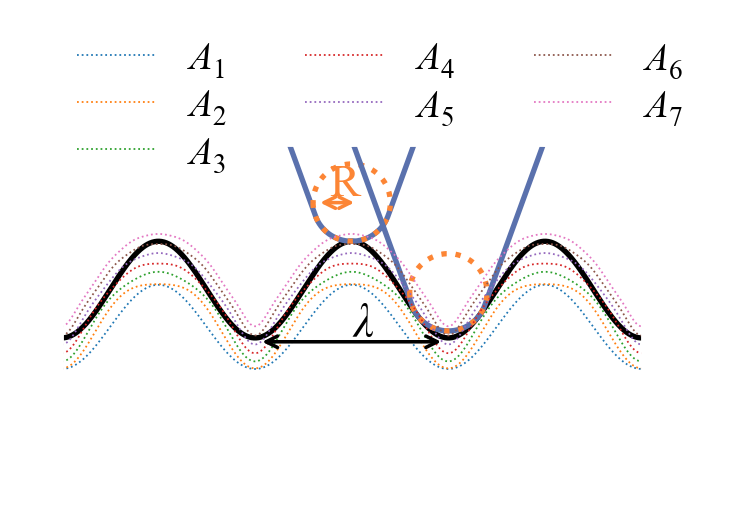

In [43]:
m=0
SurfacePlot(rackPos, Nb, waveDims, wavePos, tipDims, binSize, 0)

## Manuscript Contour Plot

In [46]:
contrast = 1
maxRF   = (TotalRF/(E_eff*indentorRadius[:,None,None]**2)).max()
normalizer = mpl.colors.PowerNorm(0.45, 0, contrast*maxRF)

In [47]:
N = 10
n0, n1, n2 = 1, 0, 4
m = 3

/tmp/ipykernel_9972/1458460028.py:29: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))


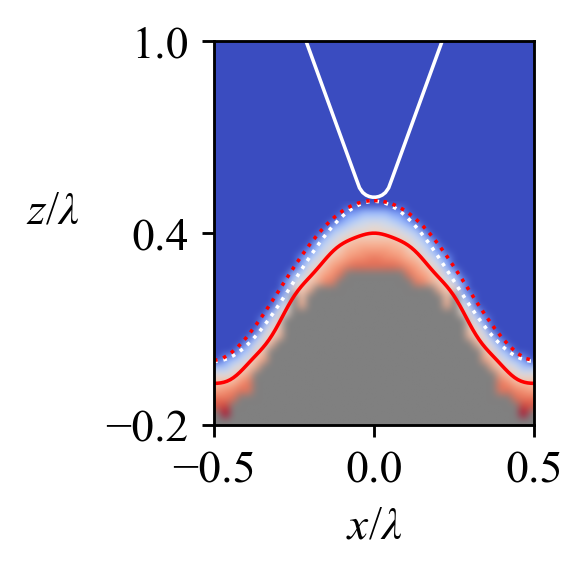

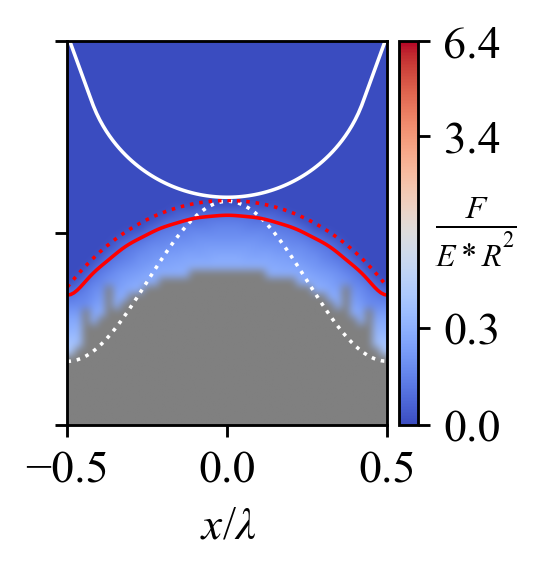

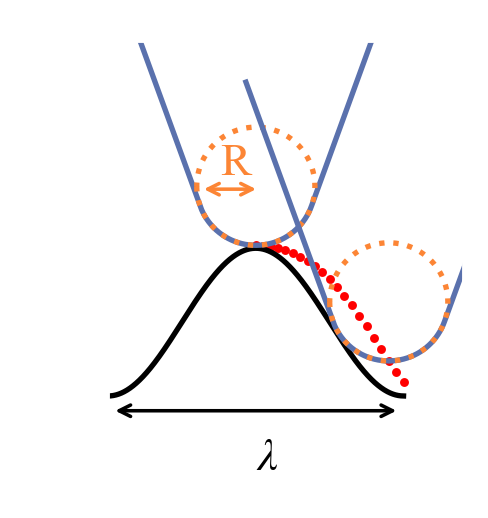

In [48]:
ContourPlotMan(X, Z, NrackPos, forceGrid[m], forceContour[m],indentorRadius, clearance, A[m+1], N, waveDims, theta_degrees, tip_length, binSize, 
               elasticProperties, normalizer, maxRF, contrast, n0, n1, n2)

## 2D Force Heat Maps and Fitted Force

In [49]:
contrast = 1
maxRF   = (TotalRF/(E_eff*indentorRadius[:,None,None]**2)).max()
normalizer = mpl.colors.PowerNorm(0.45, 0, contrast*maxRF)

### Interpolate

C:\Users\Joshg\AppData\Local\Temp\ipykernel_2392\1458460028.py:29: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))


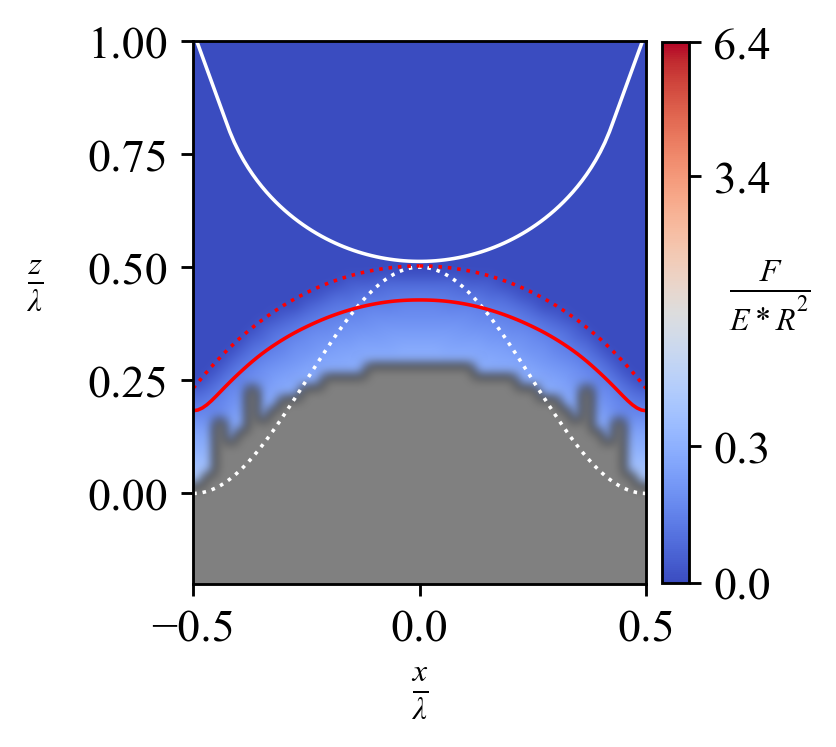

In [50]:
N = 15
n = 4
m = 8

tipDims = TipStructure(indentorRadius[n], theta_degrees, tip_length)

ContourPlot(X, Z, NrackPos[n], forceGrid[m,n], forceContour[m,n], refForces[m], clearance, A[m+1,n], N, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast)

### No Interplolate

C:\Users\Joshg\AppData\Local\Temp\ipykernel_2392\1458460028.py:29: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))


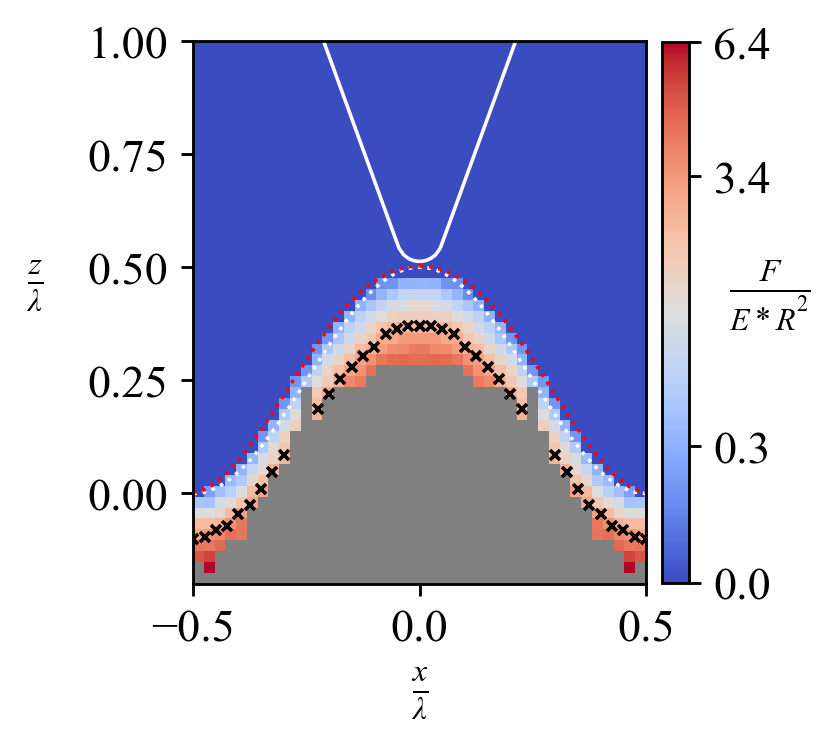

In [51]:
N = 6
n = 0
m = 5
tipDims = TipStructure(indentorRadius[n], theta_degrees, tip_length)

ContourPlotNI(X, Z, NrackPos[n], forceGrid[m,n], forceContour[m,n], refForces[m], clearance, A[m+1,n], N, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast)

### Contour Line Plot

C:\Users\Joshg\AppData\Local\Temp\ipykernel_2392\1458460028.py:29: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))
C:\Users\Joshg\AppData\Local\Temp\ipykernel_2392\33028658.py:70: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=normalizer), fraction=0.035, pad=0.02)


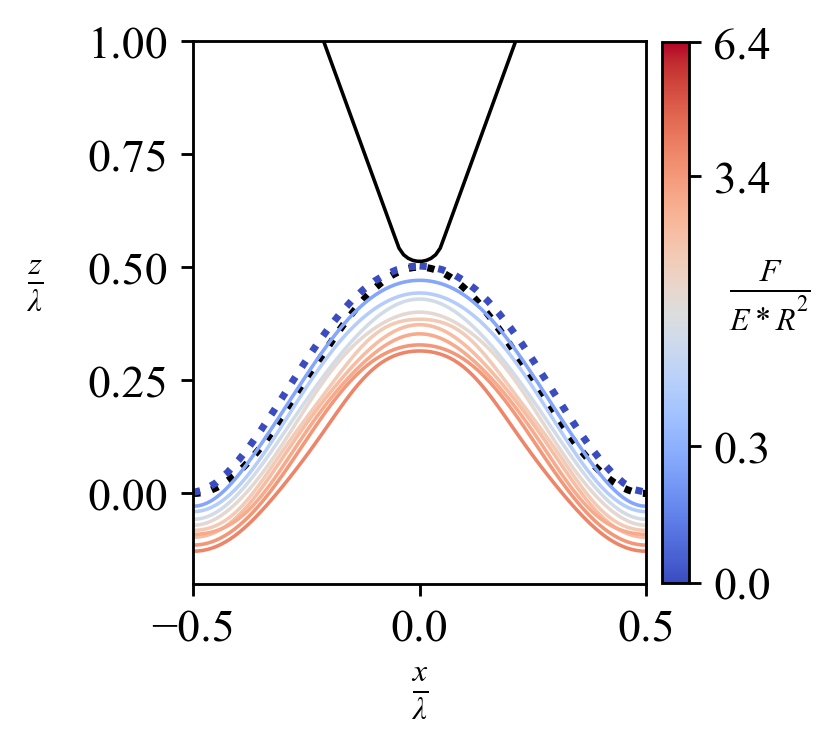

In [52]:
N = 6
n = 0

rIndentor =  indentorRadius[n]
tipDims = TipStructure(rIndentor, theta_degrees, tip_length)

LineContourPlot(X, Z, NrackPos[n], forceContour[:,n], refForces, clearance, A[:,n], N, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast)

## Force Interpolation

C:\Users\Joshg\AppData\Local\Temp\ipykernel_2392\1458460028.py:29: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))


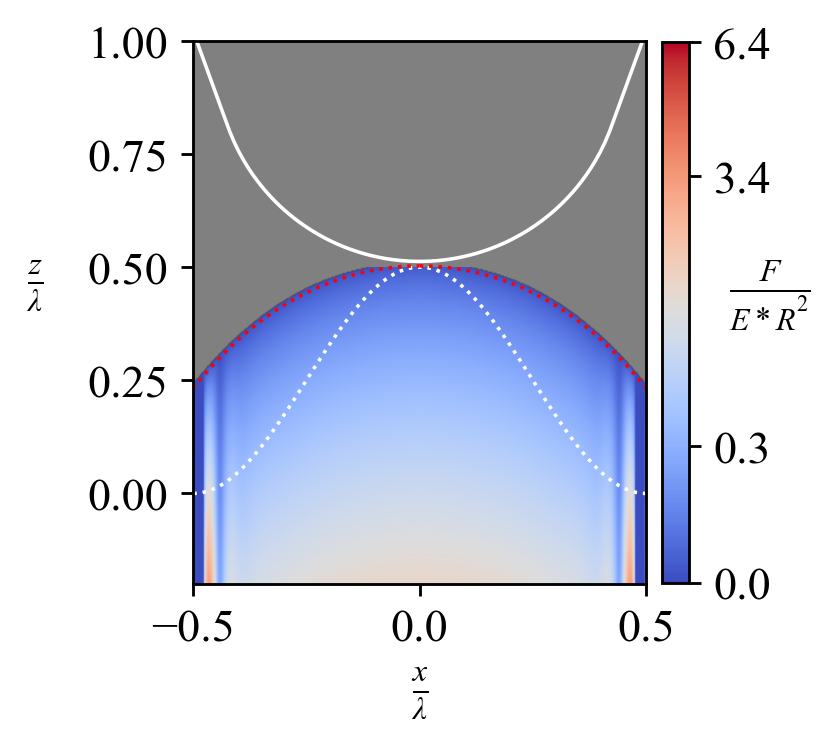

In [53]:
n = 4
tipDims = TipStructure(indentorRadius[n], theta_degrees, tip_length)

FInterpolatePlot(X, Z, NrackPos[n], F[n], clearance, waveDims, tipDims, elasticProperties, normalizer, maxRF, contrast)

## FWHM

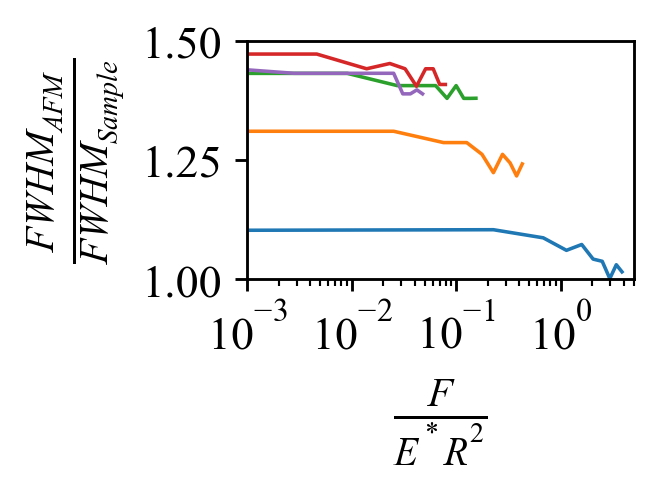

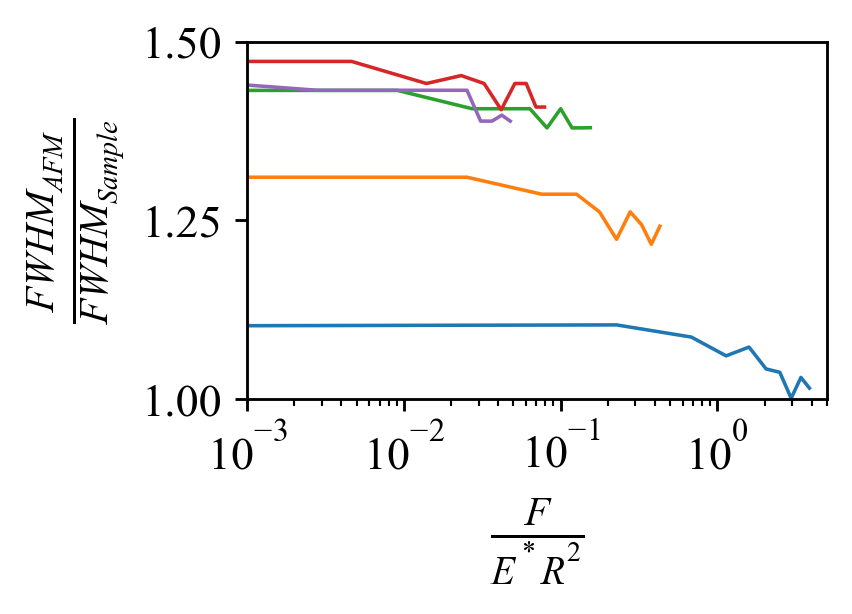

In [49]:
FWHMPlot(FWHM, indentorRadius, refForces, waveDims, elasticProperties)

## Fourier Plot

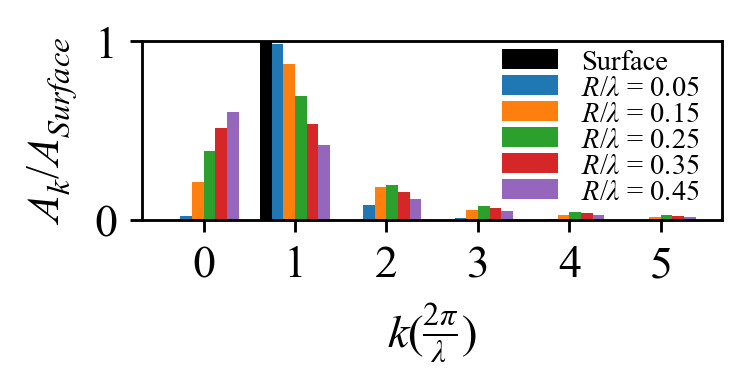

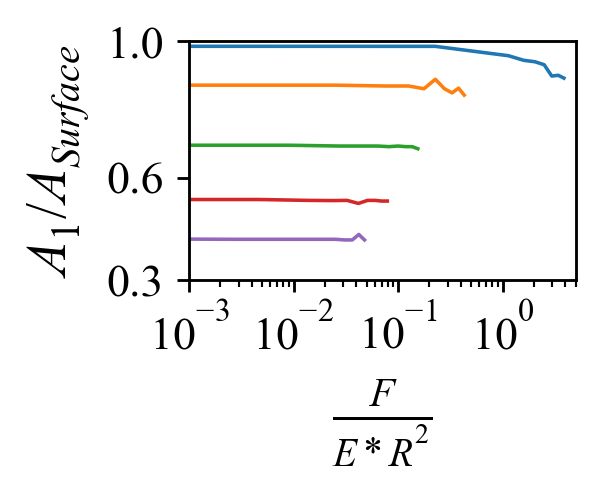

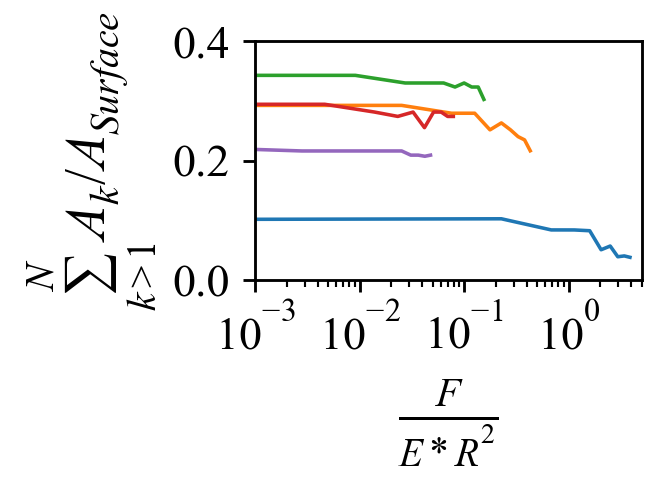

In [50]:
N = 6
m = 1
FourierPlot(X, Z, TotalRF[m], NrackPos, forceGrid[m],  forceContour[m],  refForces, m, indentorRadius, clearance, A, Nmax, N, waveDims, elasticProperties, contrast)

## Volume Plot

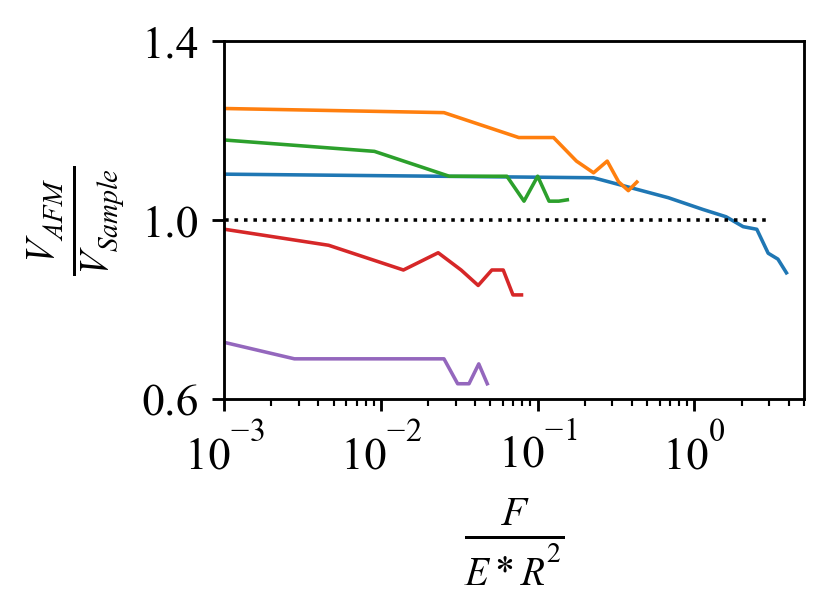

In [51]:
VolumePlot(Volume, indentorRadius, refForces, waveDims, elasticProperties )

## Youngs Modulus

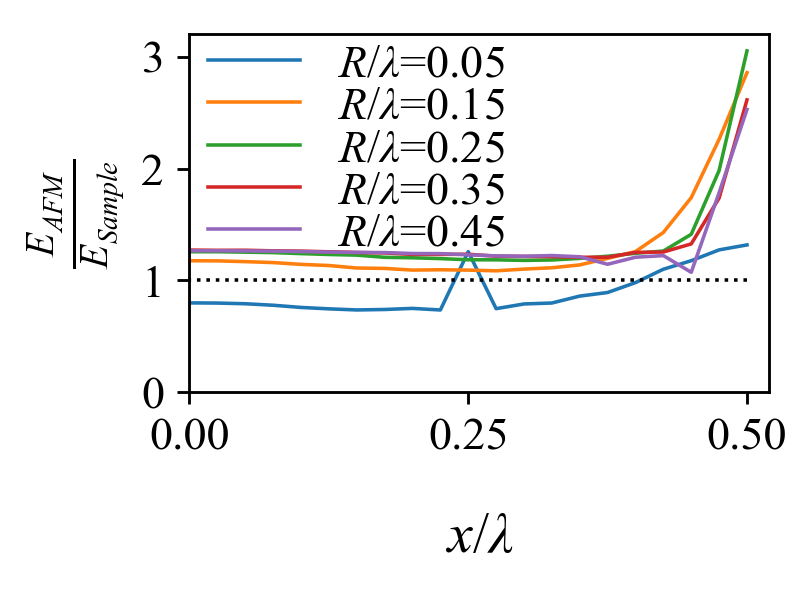

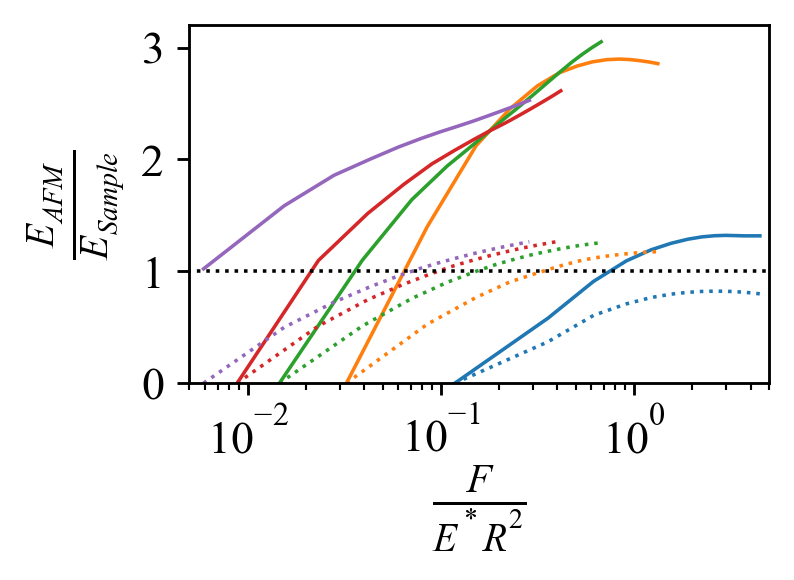

In [52]:
basePos = int((waveDims[0]/2*binSize + 1))*0
YoungPlot(E_hertz, TotalRF, indentorRadius, NrackPos, waveDims, elasticProperties, basePos)

# Bash Commands

In [51]:
RemoteCommand(remote_server, '', home, 'qstat', ProxyJump  = proxy_server)

job-ID  prior   name       user         state submit/start at     queue                          slots ja-task-ID 

-----------------------------------------------------------------------------------------------------------------

 168246 0.00000 IndenterRa zcapjgi      hqw   11/23/2023 13:28:24                                    1        

 168247 0.00000 IndenterRa zcapjgi      hqw   11/23/2023 13:29:00                                    1        

 168248 0.00000 IndenterRa zcapjgi      hqw   11/23/2023 13:29:37                                    1        

 168249 0.00000 IndenterRa zcapjgi      hqw   11/23/2023 13:30:12                                    1        

 168250 0.00000 IndenterRa zcapjgi      hqw   11/23/2023 13:30:48                                    1        



In [59]:
# RemoteCommand(remote_server, '', home, "qdel '*' ")

In [60]:
# t0 = time.time()
# RemoteCommand(remote_server, '', scratch, "find . -name '*.023' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.cid' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.dat' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.lck' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.mdl' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.com' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.msg' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.prt' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.sim' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.sta' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.stt' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.tmp' -delete")
# RemoteCommand(remote_server, '', scratch, "find . -name '*.SMABulk' -delete")
# RemoteCommand( remote_server, '', scratch, "find . -name '*.SMAFocus' -delete")

# t1 = time.time()
# print(t1-t0)